In [1]:
include("../pic3d.jl")
using .PIC3D
using PyPlot
using LinearAlgebra
using PyCall
anim =  pyimport("matplotlib.animation");

In [2]:
function generate_particles!(NP, d)
    num = d / (2*NP / (PIC3D.XL*PIC3D.YL*PIC3D.ZL))
    println(num)
    electrons = PIC3D.Species(q=PIC3D.q_e*num, m=PIC3D.m_e*num)
    ions = PIC3D.Species(q=-PIC3D.q_e*num, m=PIC3D.m_e*num*2000)
    @inbounds for i = 1:NP
        x = [rand()*PIC3D.XL, rand()*PIC3D.YL, rand()*PIC3D.ZL]
        v = [5e5, 0, 0]
        push!(electrons.x, [x...])
        push!(electrons.v, [v...])
        push!(ions.x, [x...])
        push!(ions.v, [v...])
        
        x = [rand()*PIC3D.XL, rand()*PIC3D.YL, rand()*PIC3D.ZL]
        v = [-5e5, 0, 0]
        push!(electrons.x, [x...])
        push!(electrons.v, [v...])
        push!(ions.x, [x...])
        push!(ions.v, [v...])
    end

    return electrons, ions
end

generate_particles! (generic function with 1 method)

In [3]:
function compute_EK_particles(electrons, ions)
    ek = 0
    @inbounds for i in eachindex(electrons.v)
        ek += electrons.m*dot(electrons.v[i], electrons.v[i])
    end
    @inbounds for i in eachindex(ions.v)
        ek += ions.m*dot(ions.v[i], ions.v[i])
    end
    ek = 0.5*ek
    return ek
end

function compute_EP_field()
    ep = 0
    @inbounds for k = 1:(PIC3D.NZ-1), j = 1:(PIC3D.NY-1), i = 1:(PIC3D.NX-1)
        ep += PIC3D.Ex[i,j,k]^2 + PIC3D.Ey[i,j,k]^2 + PIC3D.Ez[i,j,k]^2
    end
    ep = 0.5 * PIC3D.ε_0 * ep * PIC3D.Δx*PIC3D.Δy*PIC3D.Δz
    return ep
end


function compute_EP_potential()
    ep = 0
    @inbounds for k = 1:(PIC3D.NZ-1), j = 1:(PIC3D.NY-1), i = 1:(PIC3D.NX-1)
        ep += PIC3D.ρ[i,j,k] * PIC3D.ϕ[i,j,k]
    end
    ep = 0.5* PIC3D.ε_0 *ep
    return ep
end

compute_EP_potential (generic function with 1 method)

In [39]:
size(historyxx)

(120,)

MovieWriter ffmpeg unavailable; using Pillow instead.


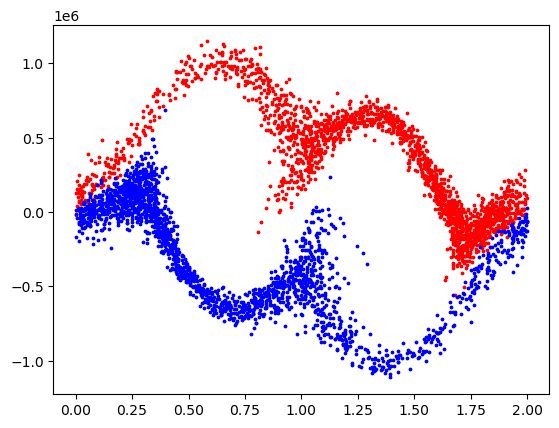

In [44]:
fig = plt.figure()

function make_frame(i)
    plt.clf()
    firstx = historyxx[i+1][1:2:(size(historyxx[1])[1])]
    firstv = historyvel[i+1][1:2:(size(historyxx[1])[1])]
    plt.scatter([p[1] for p in firstx], [p[1] for p in firstv], s =3, color="red")
    secondx = historyxx[i+1][2:2:(size(historyxx[1])[1] )]
    secondv = historyvel[i+1][2:2:(size(historyxx[1])[1])]
    plt.scatter([p[1] for p in secondx], [p[1] for p in secondv], s =3, color="blue")
end

myanim = anim.FuncAnimation(fig, make_frame, frames=120, interval=50, blit=false)
myanim[:save]("nowy1.gif", bitrate=-1)


In [ ]:
NP = 2048 #2048
d = 4.5e9
electrons, ions = generate_particles!(NP, d)

Δt = 1e-9
timesteps = 1000

historyxx = []
historyvel = []
EK = []
EE = []
EP = []

for i = 1:timesteps
    println(i)
    PIC3D.timestep_multigrid!(electrons, ions)
    if i % 25 == 0
        plt.figure()
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 0],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 0], color="red", label="c = 1", s=2)
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 1],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 1], color="blue", label="c = 1", s=2)
        plt.xlabel("x [m]")
        plt.ylabel("vel x [m/s]")
        plt.show()
        push!(historyxx, [[ex...] for ex in electrons.x])
        push!(historyvel, [[ev...] for ev in electrons.v])
    end
    push!(EK, compute_EK_particles(electrons, ions))
    push!(EE, compute_EP_field())
    push!(EP, compute_EP_potential())
end

562500.0000000001
1
Converged after 23 cycles, L2 = 6.4743364301525096e-9
2
Converged after 24 cycles, L2 = 9.987316469304223e-9
3
GS failed to converge, L2 = 2.92841351147915e-8
4
GS failed to converge, L2 = 5.852765745928741e-8
5
GS failed to converge, L2 = 9.776370905163419e-8
6
GS failed to converge, L2 = 1.4727381147377515e-7
7
GS failed to converge, L2 = 2.06980009715889e-7
8
GS failed to converge, L2 = 2.765859985556669e-7
9


In [50]:
PIC3D.R1

16×16×16 Array{Float64, 3}:
[:, :, 1] =
 0.0129601   0.00820505  0.00701673   …  0.00717385  0.00872798  0.00564526
 0.00925197  0.00510987  0.00483159      0.00523815  0.00557456  0.0029842
 0.00818709  0.00458208  0.0040803       0.00424956  0.005092    0.00265645
 0.00753733  0.00430691  0.00330688      0.00387216  0.00453096  0.00235647
 0.00706932  0.00373078  0.00266638      0.00314363  0.00435033  0.00221972
 0.006297    0.00330548  0.00207293   …  0.00317398  0.00396401  0.00220216
 0.00606465  0.00284507  0.00159563      0.00333047  0.00399798  0.00183754
 0.00542816  0.00266458  0.00159335      0.00301181  0.0032553   0.00193738
 0.00502406  0.00217788  0.00137795      0.00219973  0.00338322  0.00135153
 0.00462183  0.00241601  0.00120981      0.00216767  0.00269117  0.00150643
 0.00445568  0.00183747  0.000793887  …  0.00186322  0.00246441  0.00103283
 0.00425671  0.00235339  0.00185271      0.00188109  0.00242045  0.00205709
 0.00624541  0.00347313  0.00247243      0.002478

In [55]:
PIC3D.EPS8

2×2×2 Array{Float64, 3}:
[:, :, 1] =
 0.0072669   0.00718281
 0.00721519  0.00716013

[:, :, 2] =
 0.00720856  0.00714914
 0.00717293  0.00714192

In [41]:
PIC3D.R4

4×4×4 Array{Float64, 3}:
[:, :, 1] =
 -0.00826759  -0.00400456   -0.00200748   -0.00411397
 -0.00481917  -0.000815875   8.12187e-5   -0.00190853
 -0.00331811   0.000174366   0.000597306  -0.00128618
 -0.00421405  -0.00122261   -0.000347917  -0.00150356

[:, :, 2] =
 -0.00380133  -0.000775668  0.000565483  -0.000844462
 -0.00143001   0.000897536  0.00158245    0.000375262
 -0.00075257   0.00137087   0.00197962    0.000775077
 -0.00135452   0.00062575   0.0013397     0.000158769

[:, :, 3] =
 -0.00332605   -0.000197578  0.0010669   -0.000446561
 -0.000910269   0.00130621   0.00207197   0.000825296
  0.000484852   0.00196231   0.00262522   0.001493
 -0.000218277   0.00113838   0.00187606   0.000824789

[:, :, 4] =
 -0.00445323  -0.00131845   -0.000448835  -0.00153269
 -0.00199172   0.000498702   0.00121384   -0.000169566
 -0.00051086   0.00131307    0.00168651    0.000289157
 -0.00152352   0.000241323   0.00071097   -0.000239012

In [45]:
PIC3D.EPS4

4×4×4 Array{Float64, 3}:
[:, :, 1] =
 0.00759999  0.00754403  0.00751413  0.00755891
 0.00755901  0.0075051   0.00748389  0.0075283
 0.00753363  0.00748522  0.00746962  0.00751144
 0.00756195  0.00751649  0.00749615  0.00753356

[:, :, 2] =
 0.00754676  0.00750059  0.00747551  0.00751447
 0.00751422  0.00747269  0.0074541   0.00749122
 0.0074958   0.00745819  0.00744263  0.0074781
 0.00752053  0.0074835   0.00746546  0.00750034

[:, :, 3] =
 0.00752971  0.00748548  0.00746243  0.00750021
 0.00749812  0.00745978  0.00744189  0.00747759
 0.00747549  0.00744407  0.00742944  0.0074626
 0.00750057  0.00746924  0.00745267  0.00748522

[:, :, 4] =
 0.00756508  0.00751868  0.00749695  0.00753396
 0.00753102  0.00748863  0.00747084  0.00750892
 0.00750662  0.00747074  0.00745773  0.00749394
 0.00753445  0.00749912  0.00748368  0.00751683

562500.0000000001
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
2

sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776

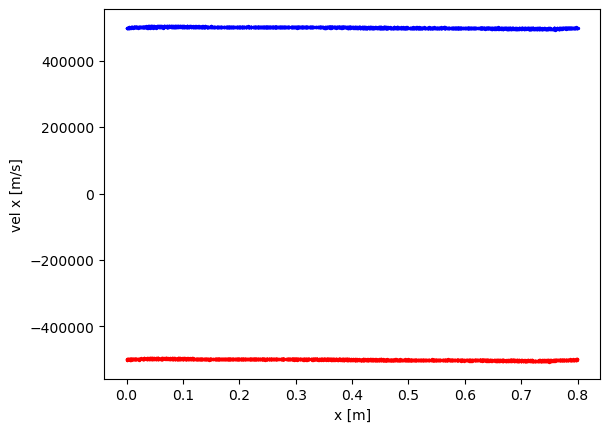

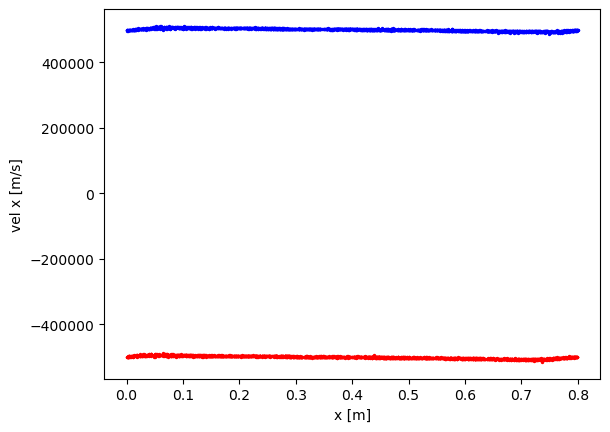

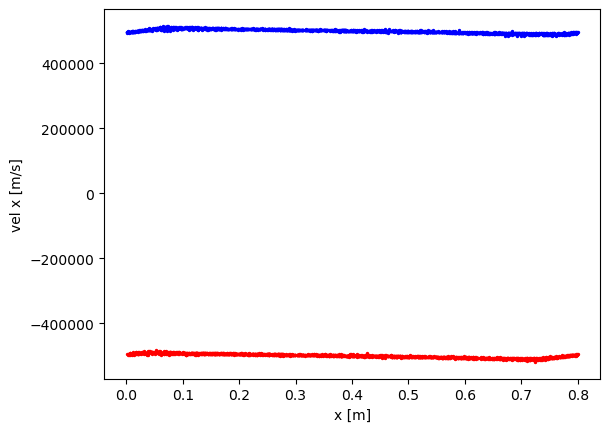

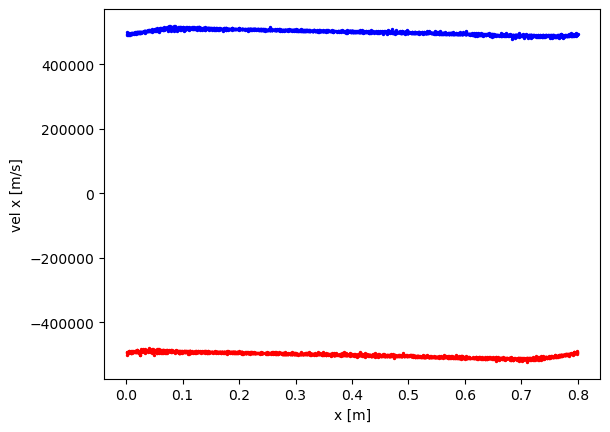

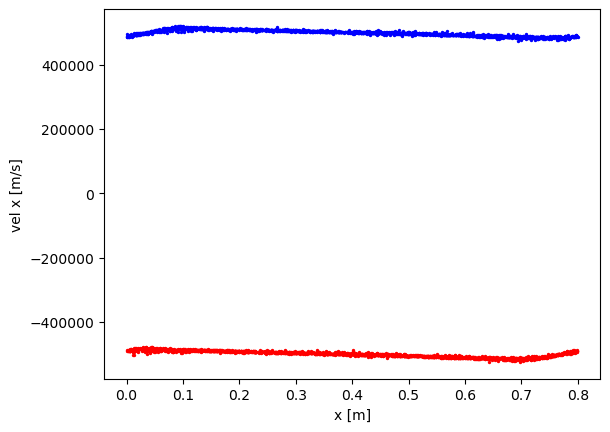

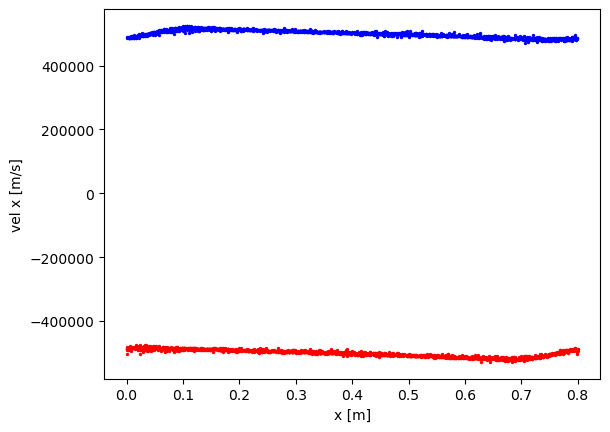

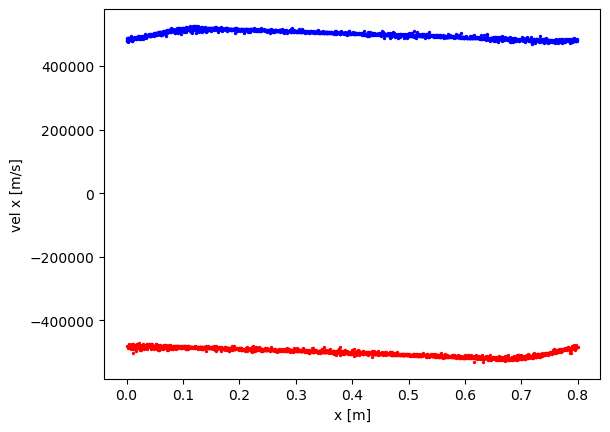

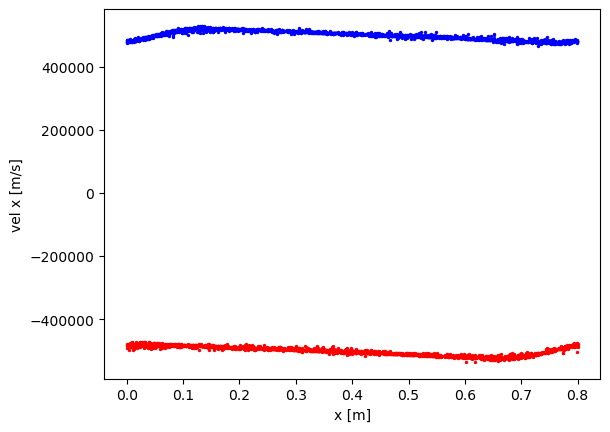

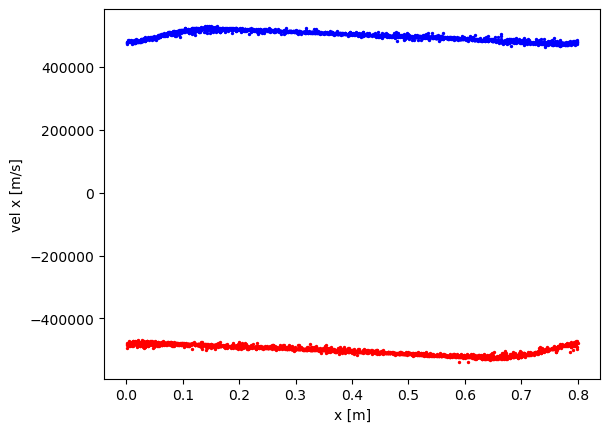

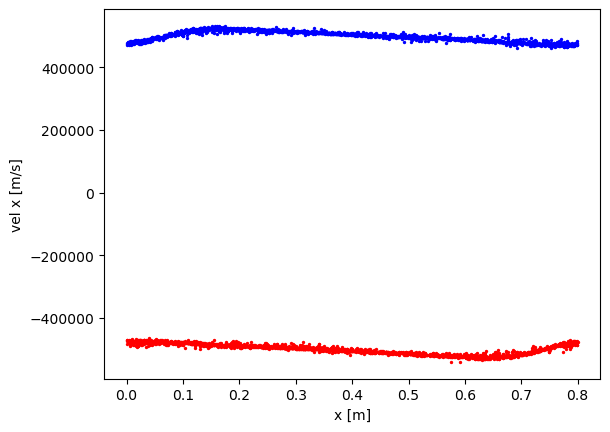

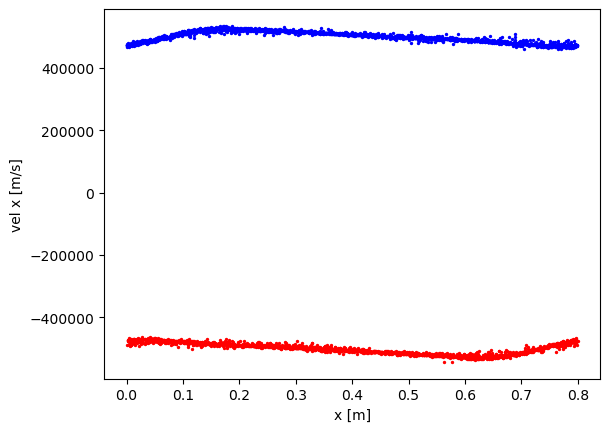

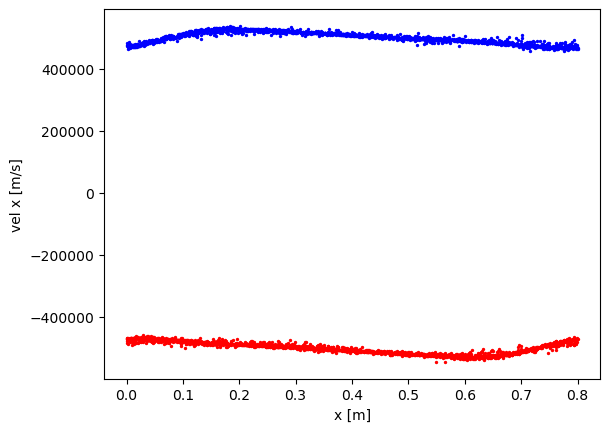

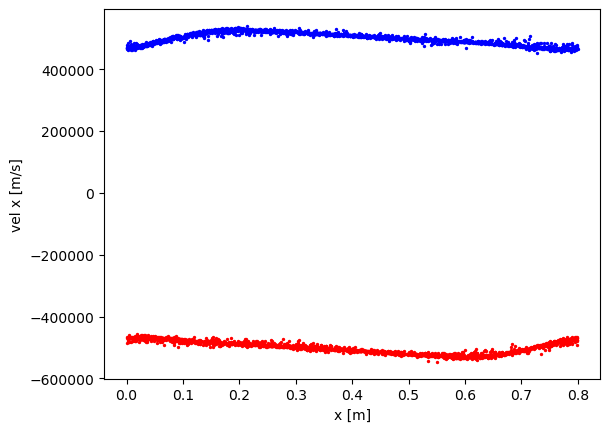

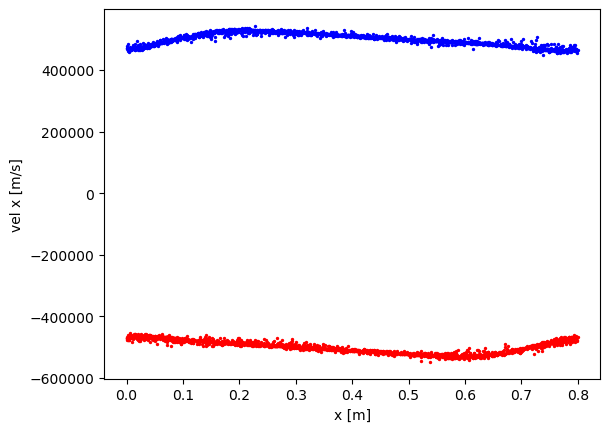

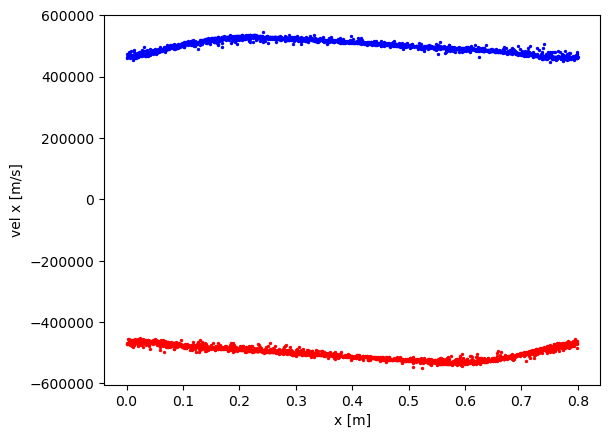

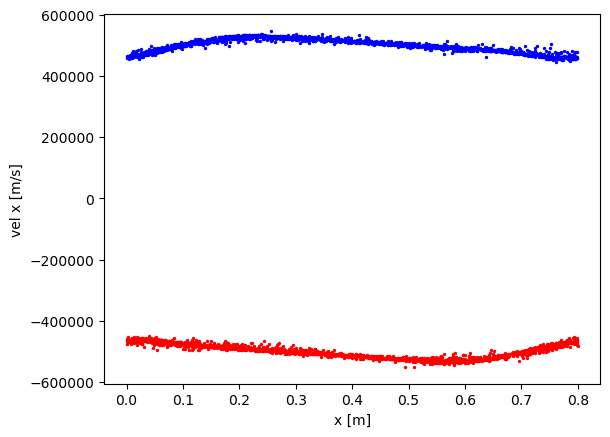

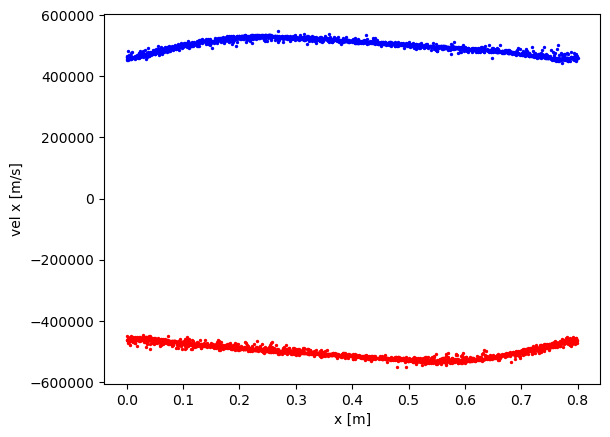

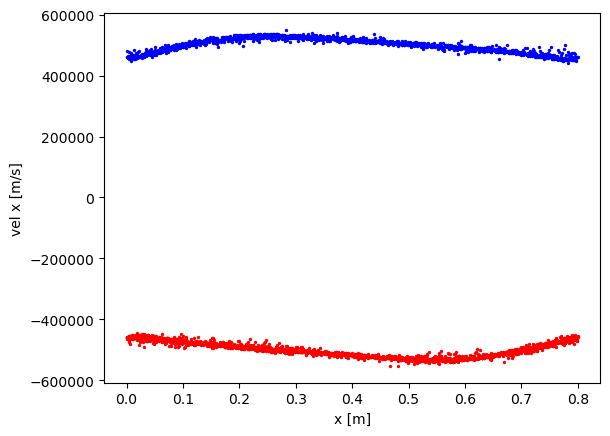

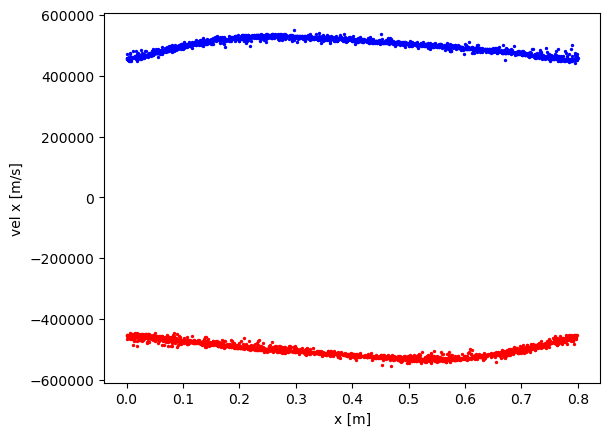

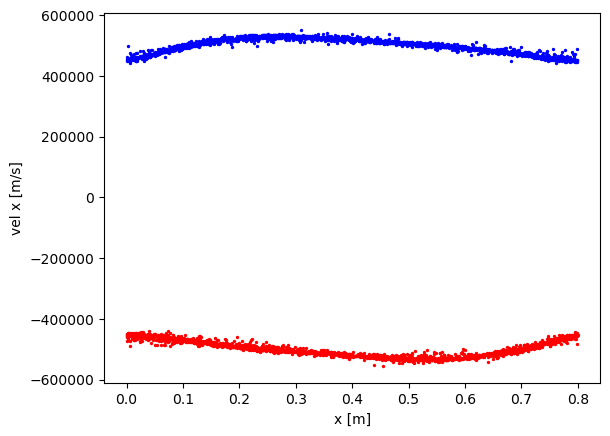

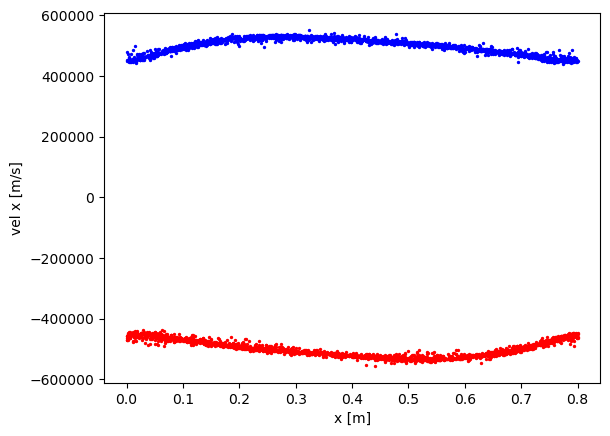

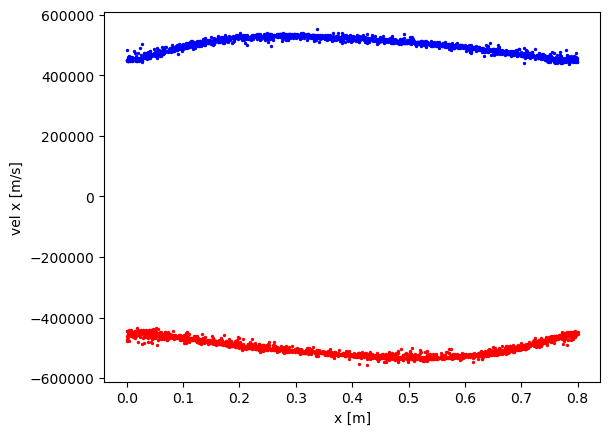

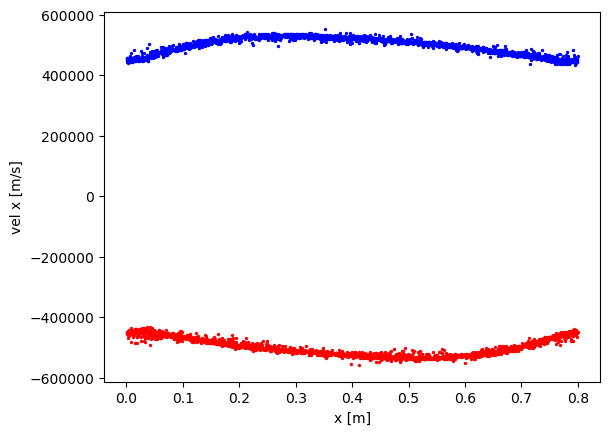

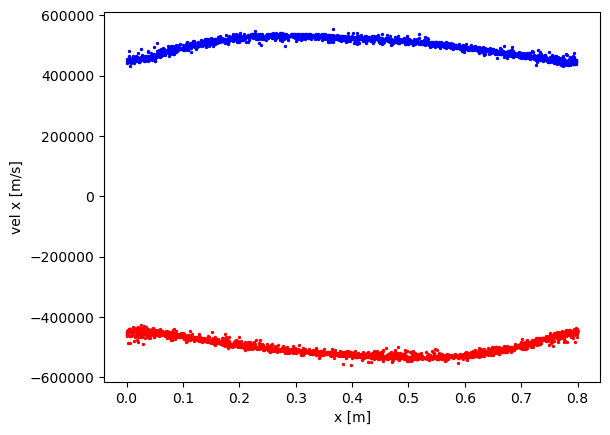

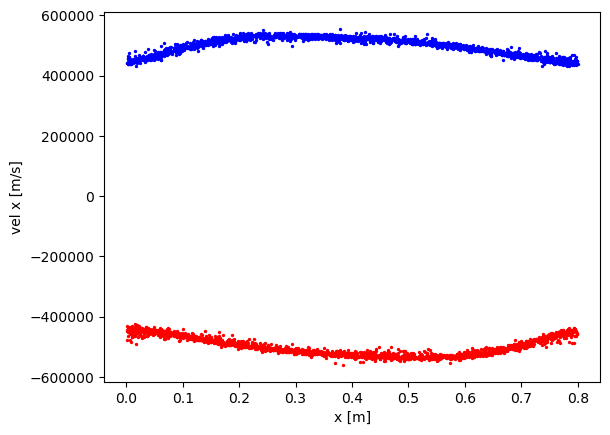

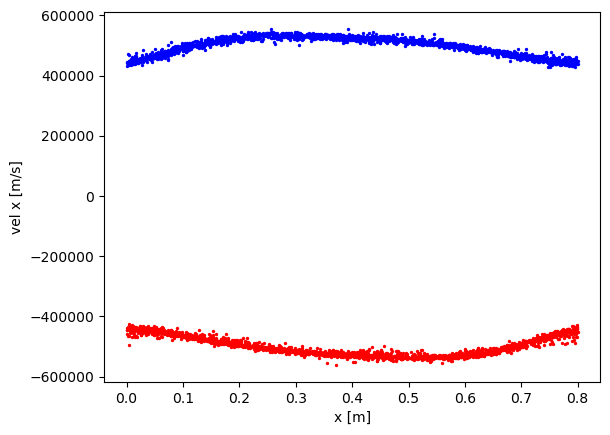

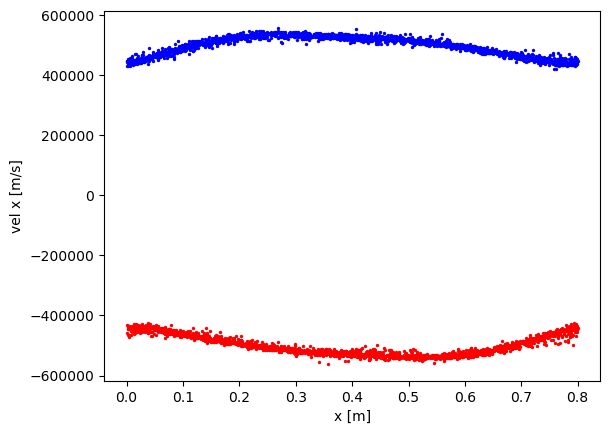

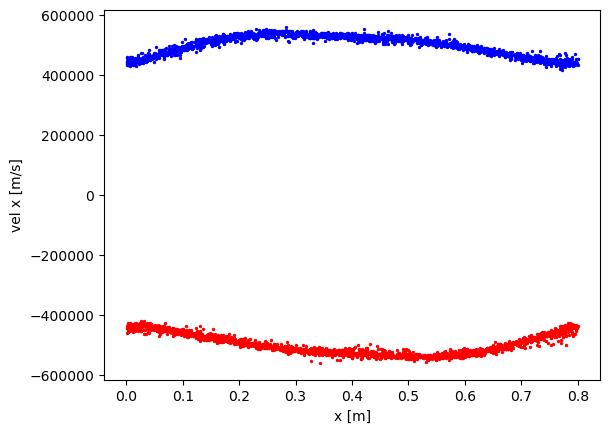

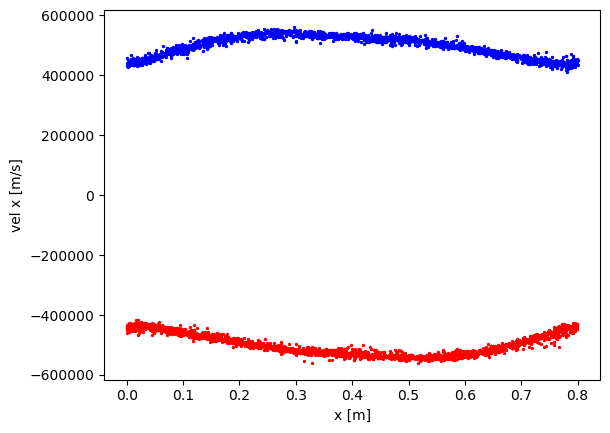

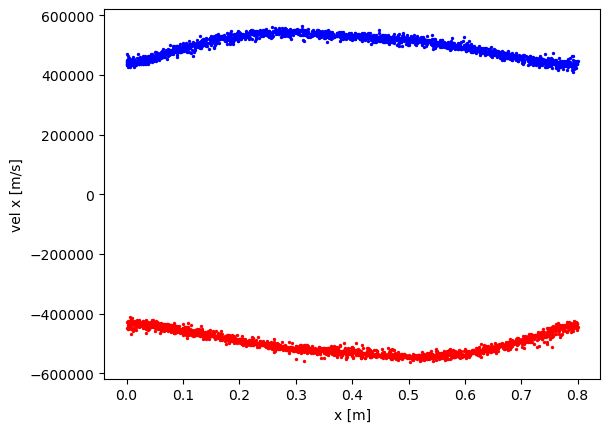

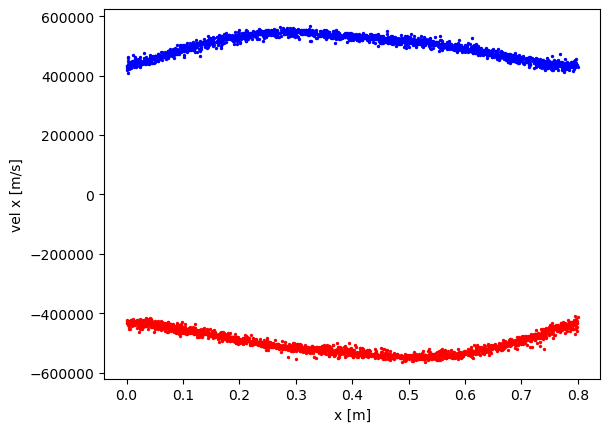

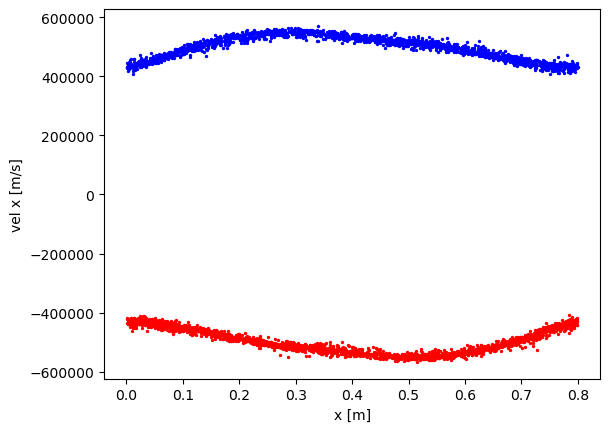

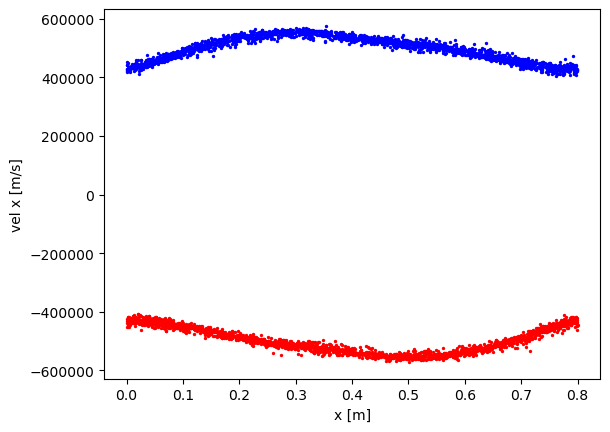

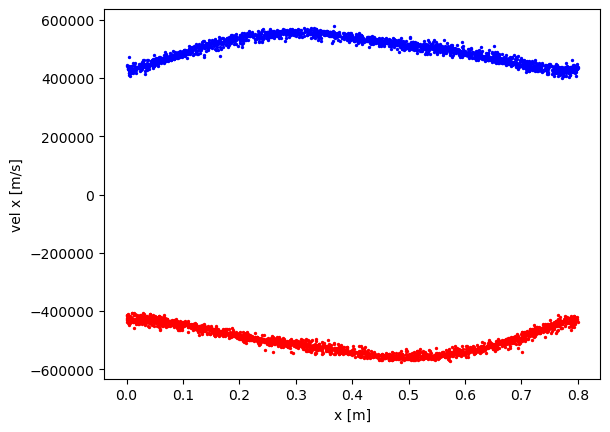

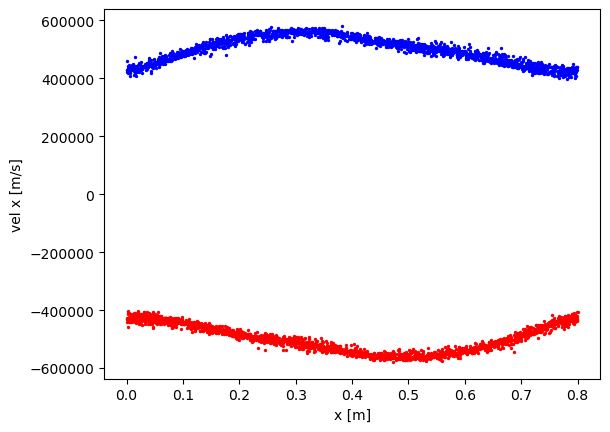

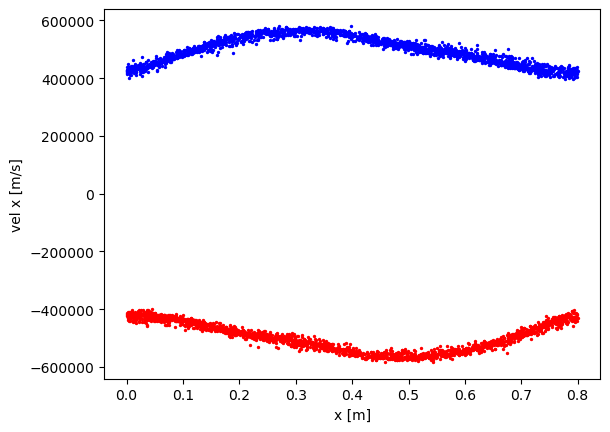

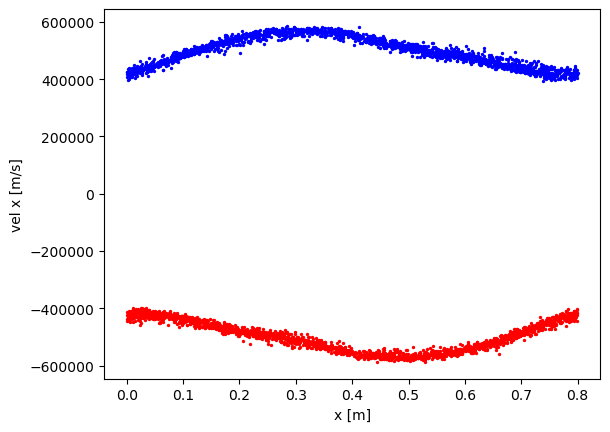

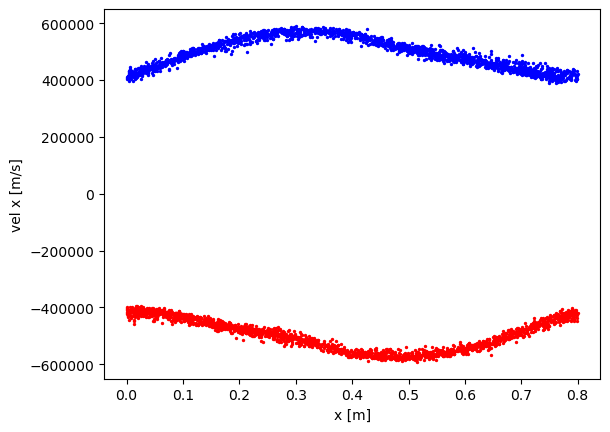

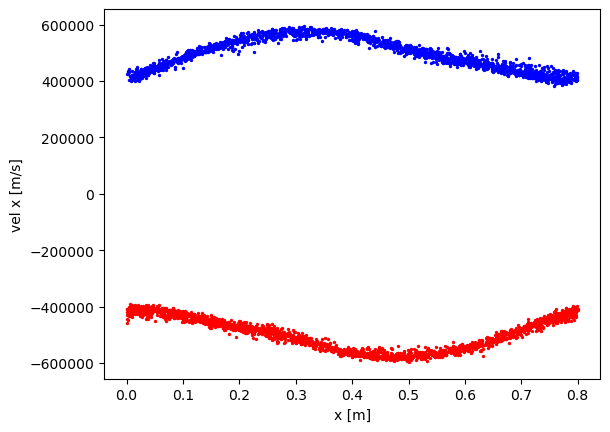

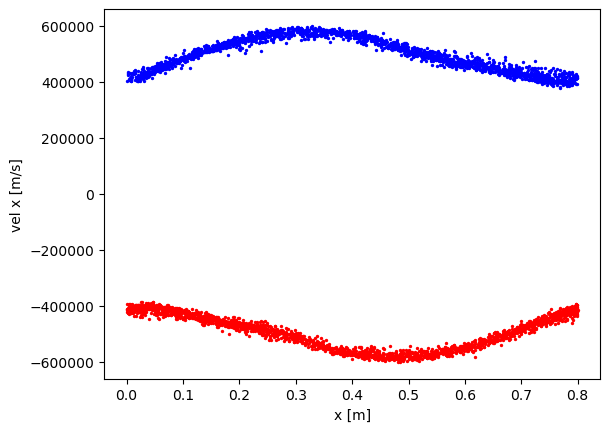

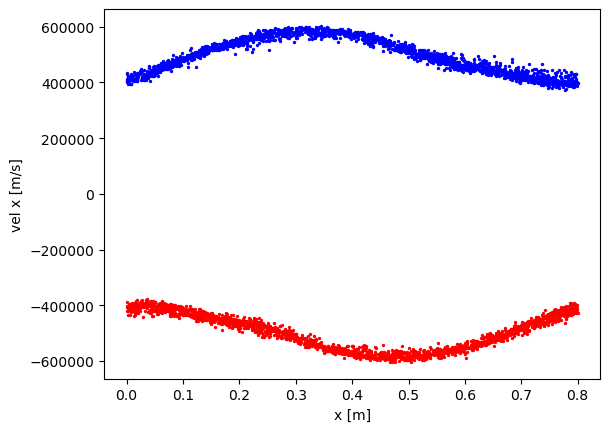

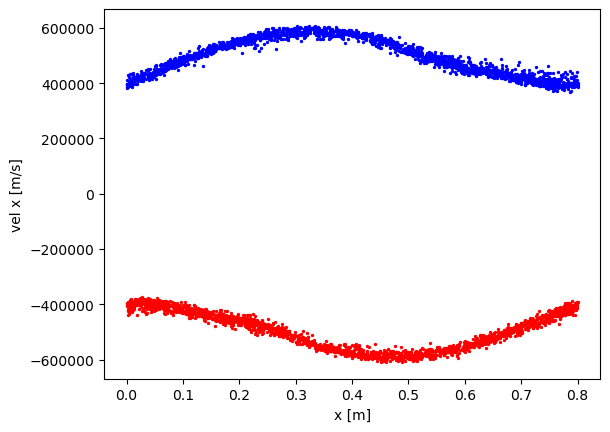

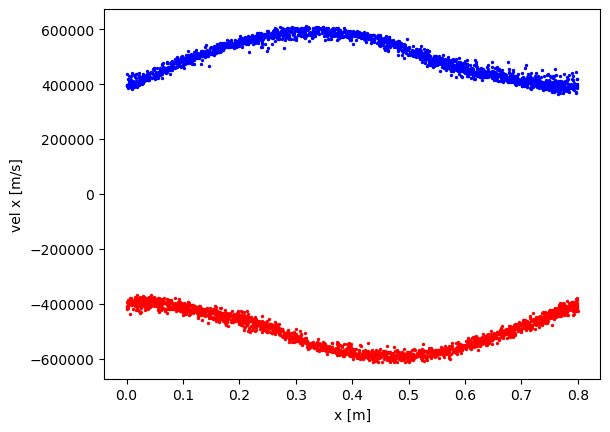

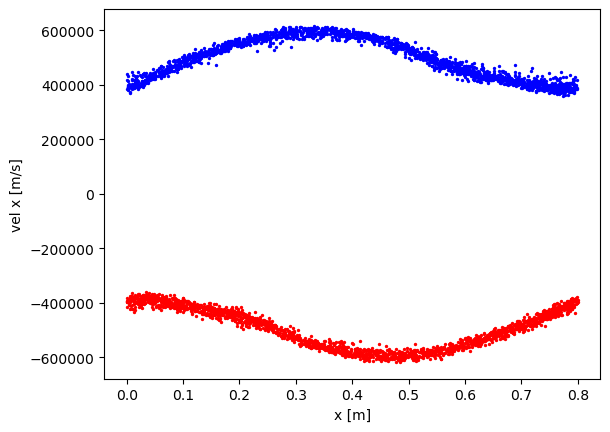

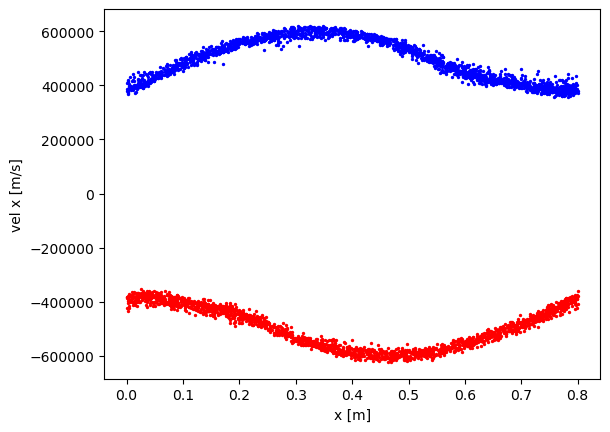

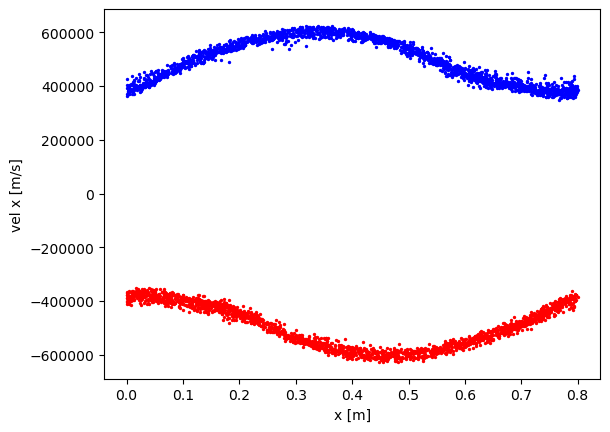

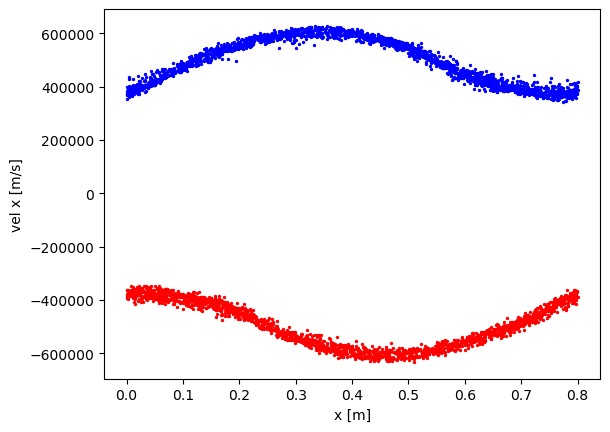

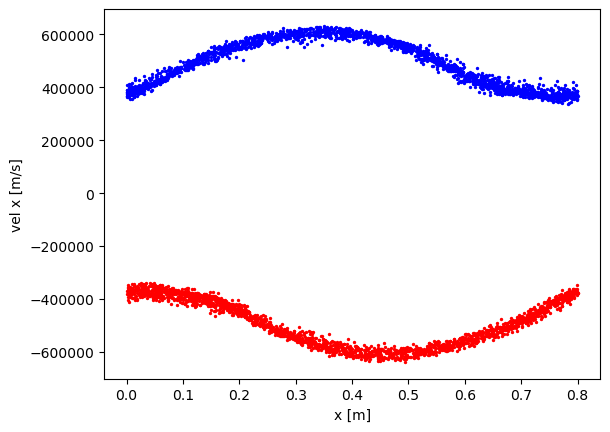

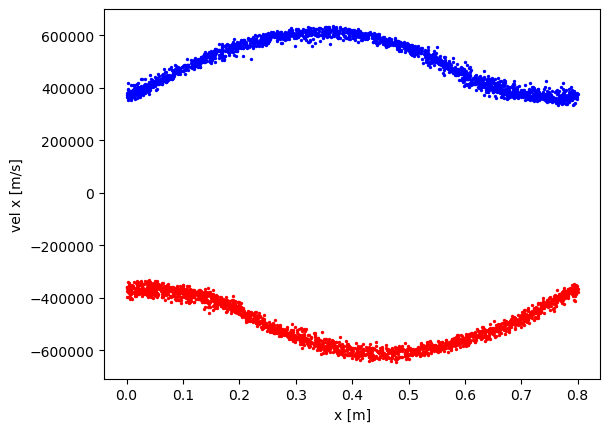

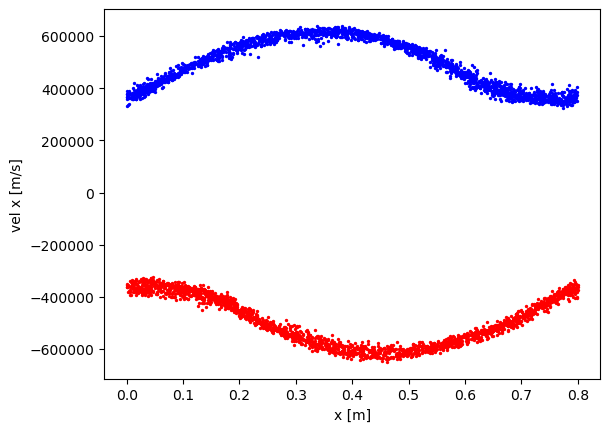

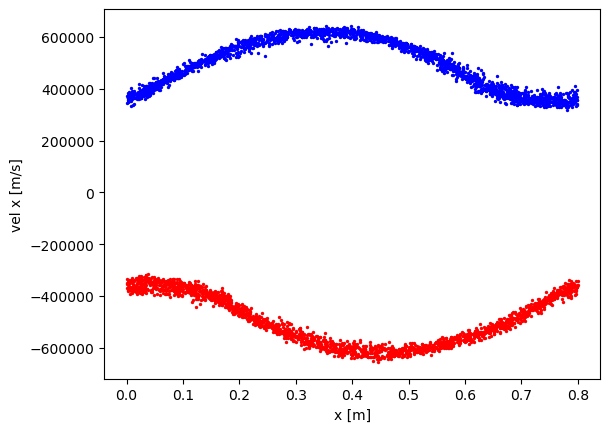

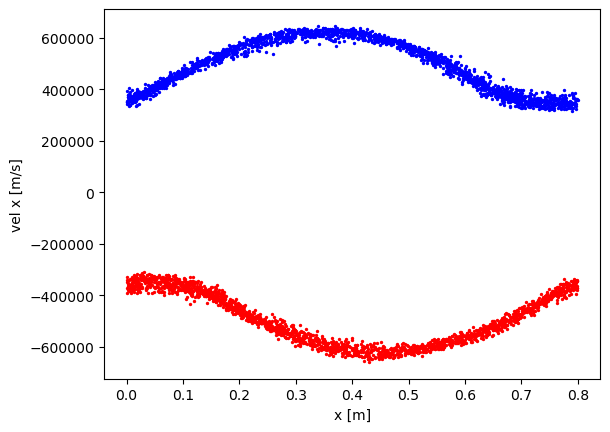

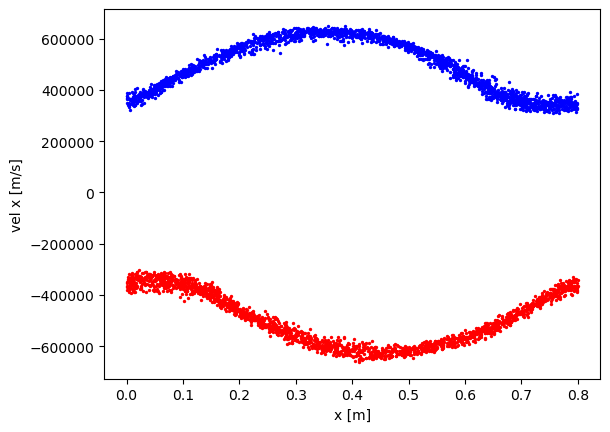

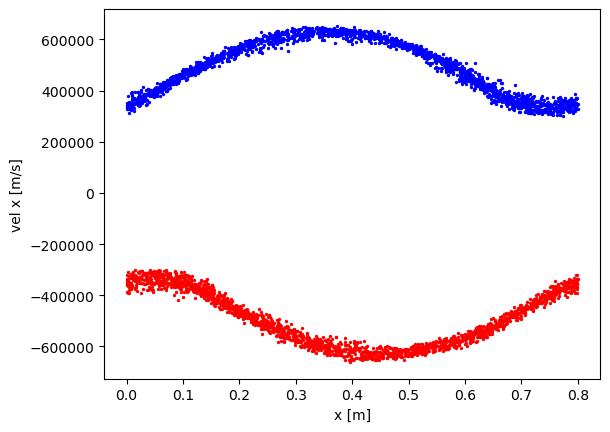

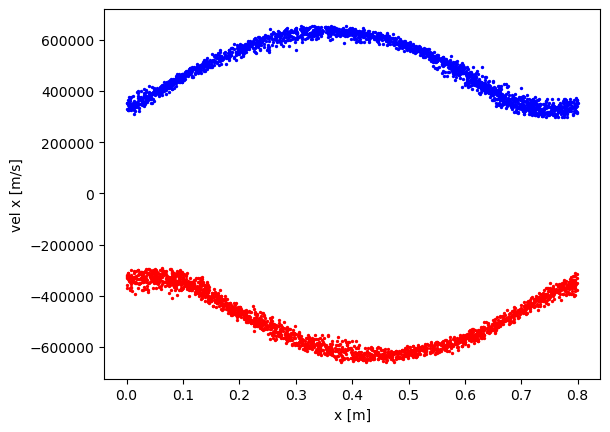

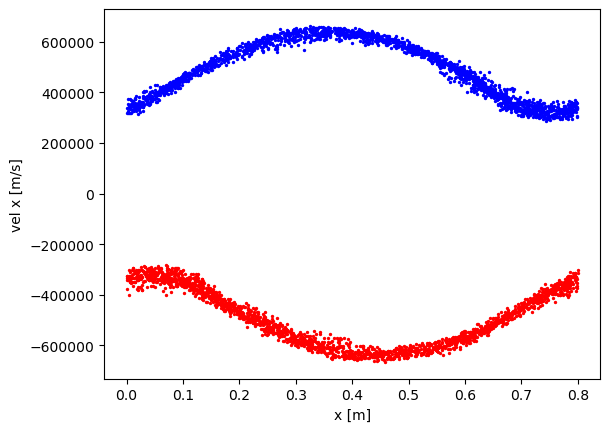

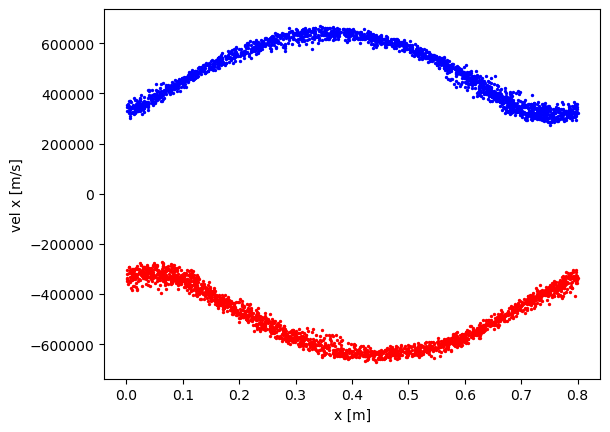

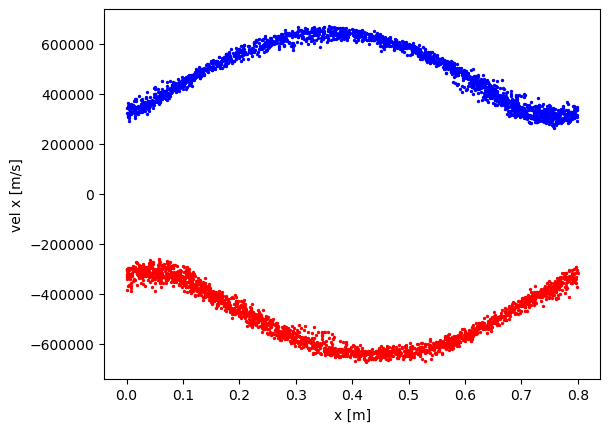

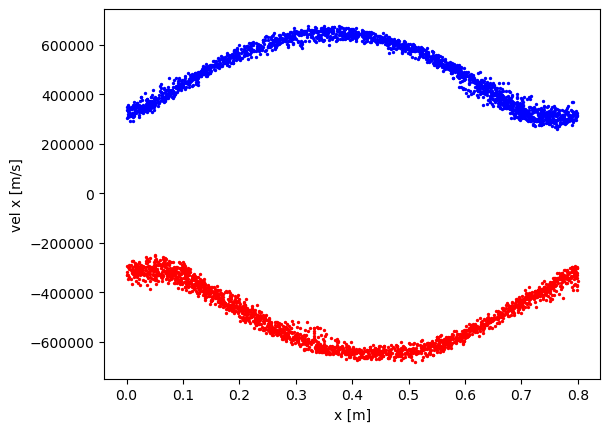

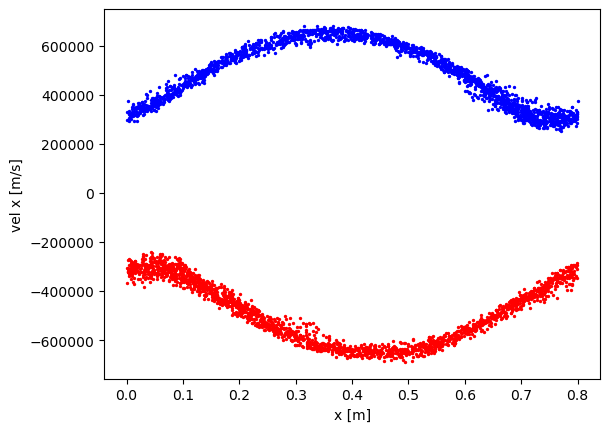

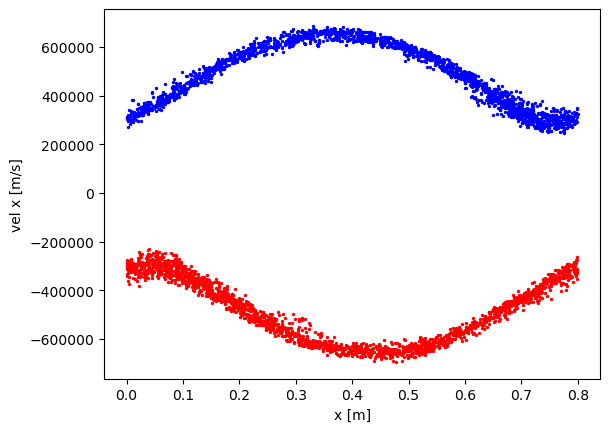

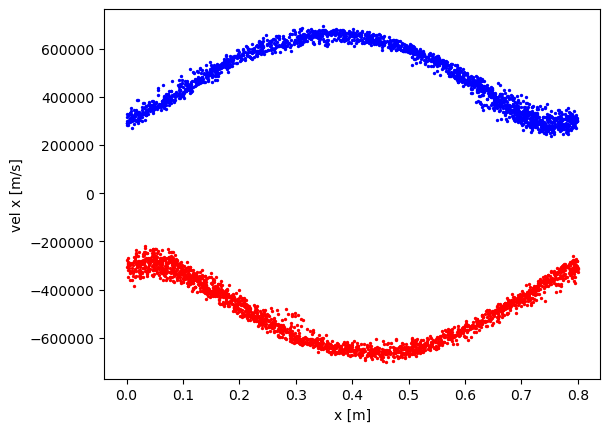

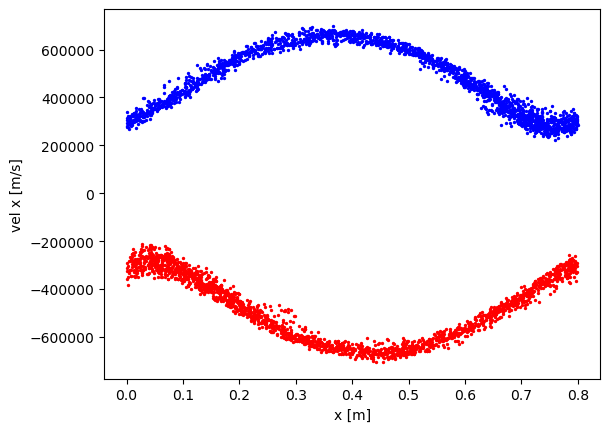

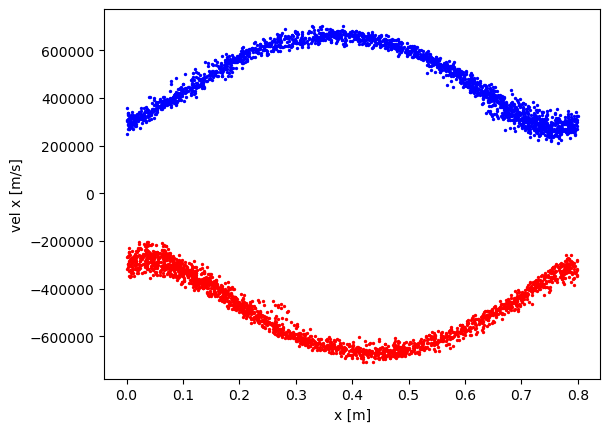

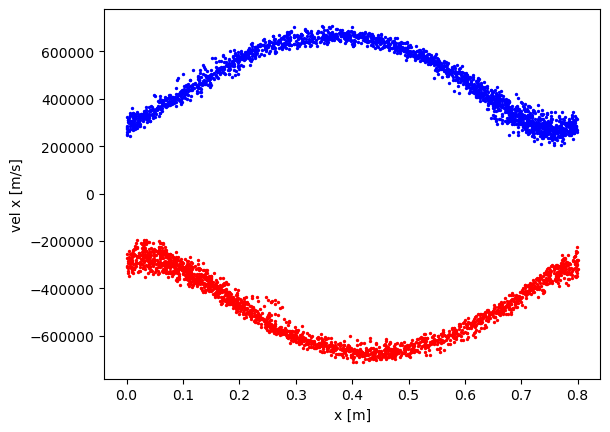

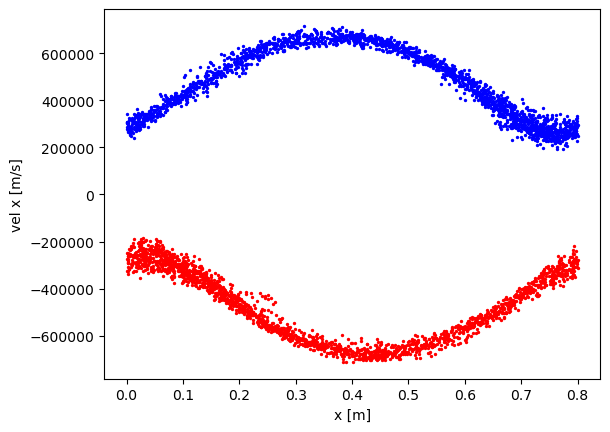

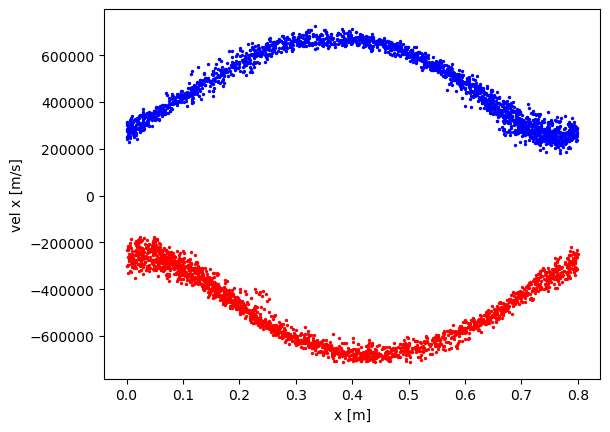

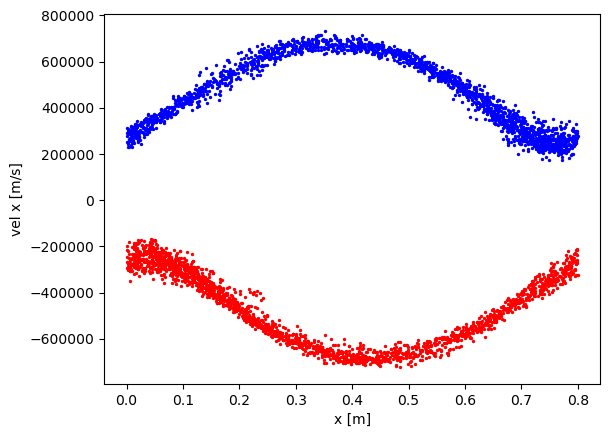

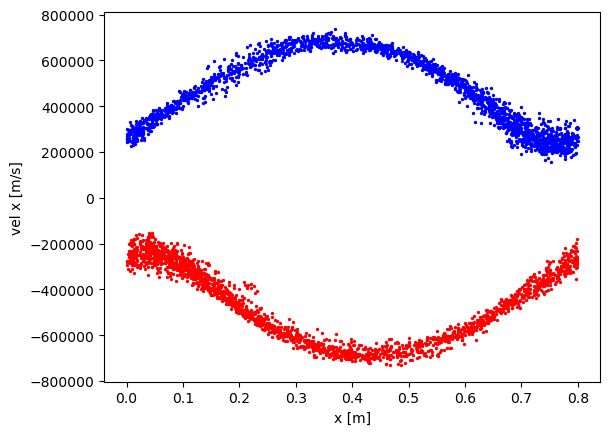

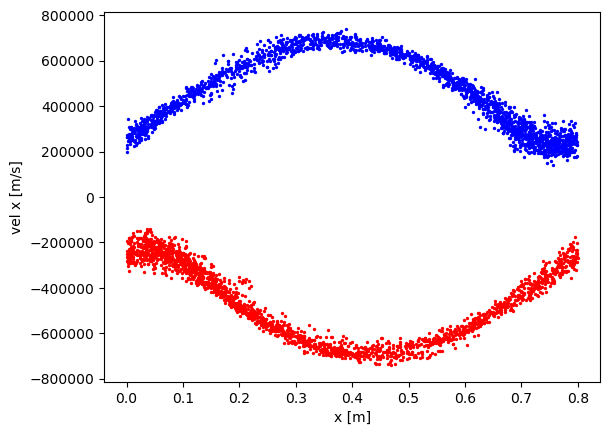

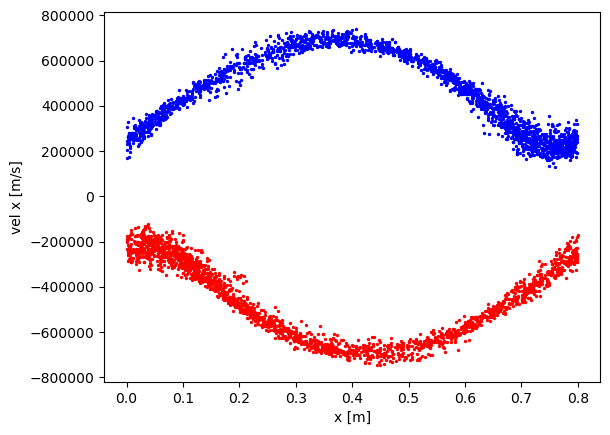

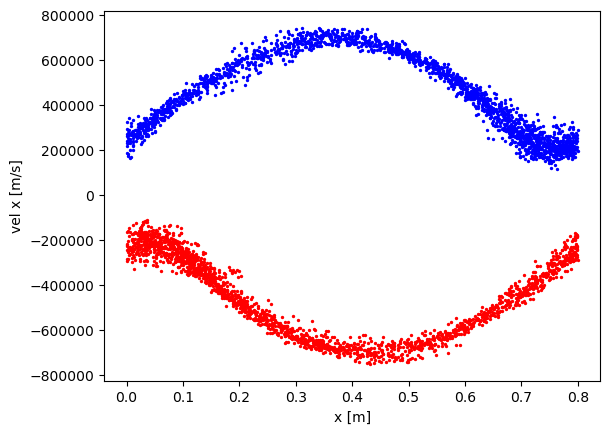

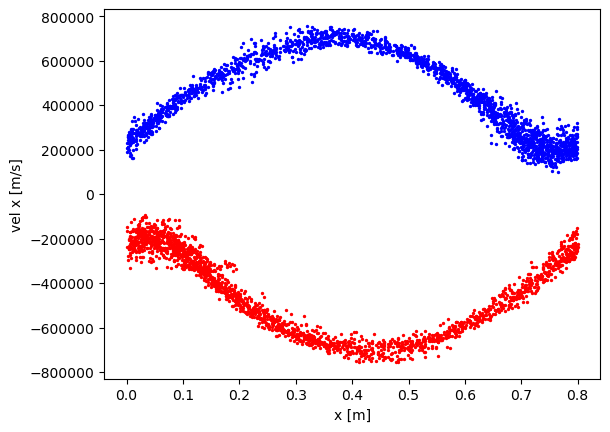

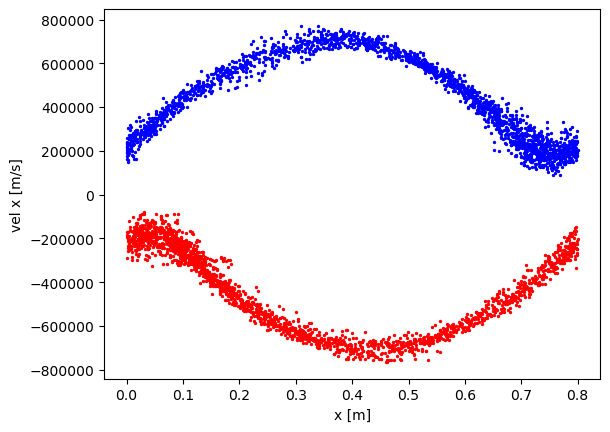

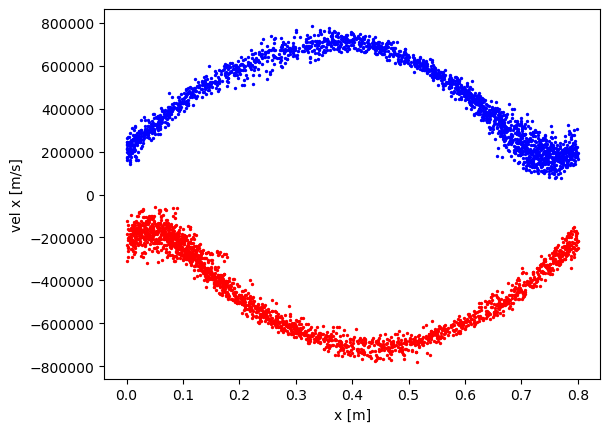

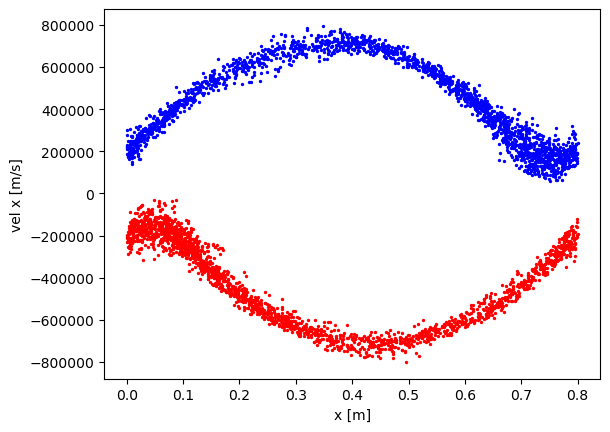

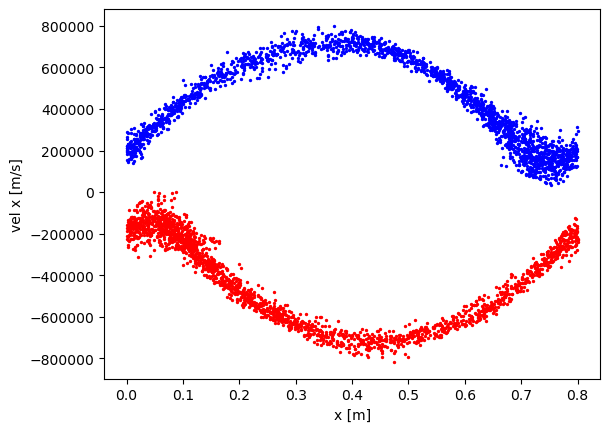

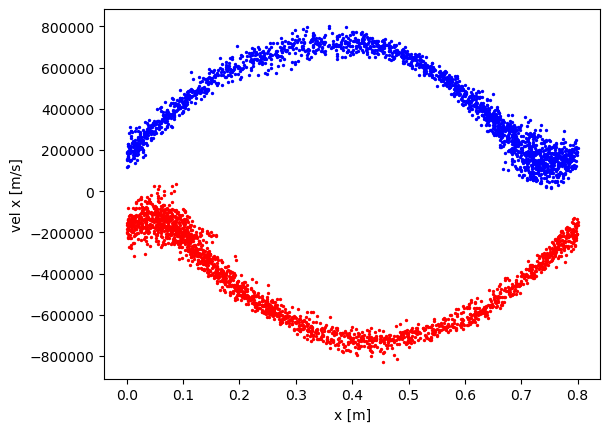

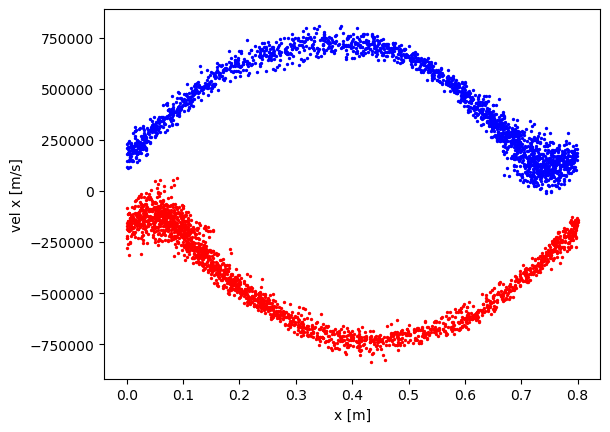

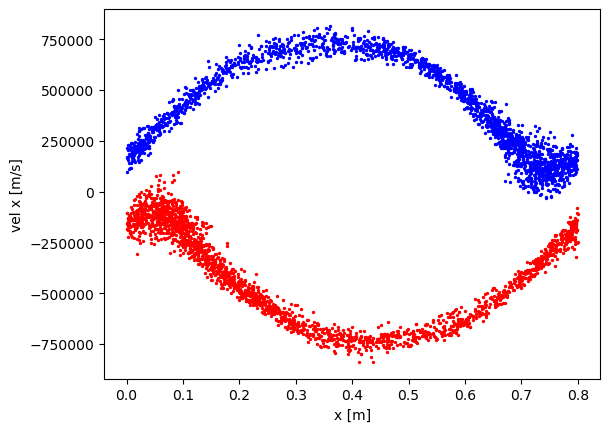

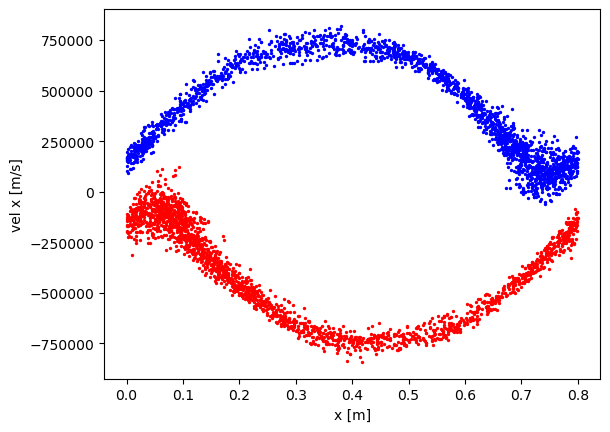

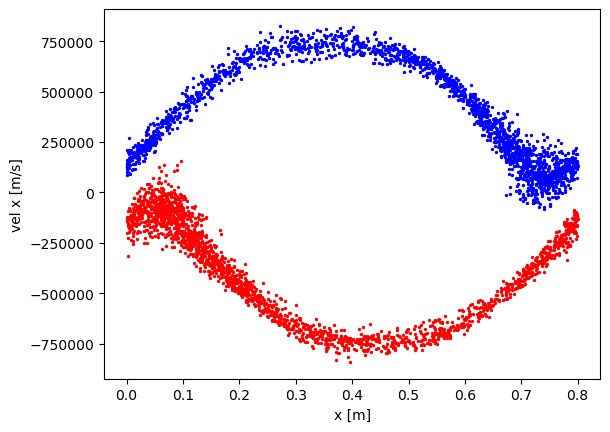

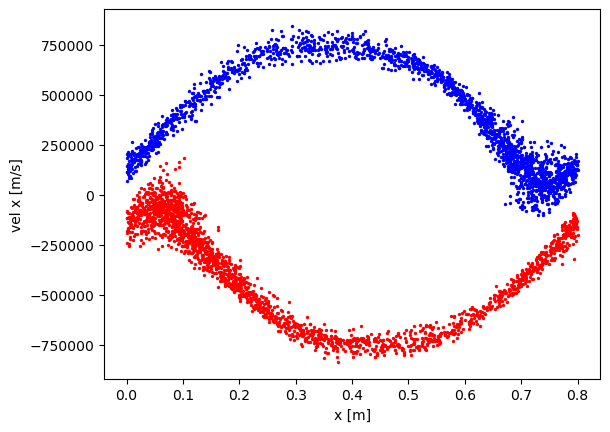

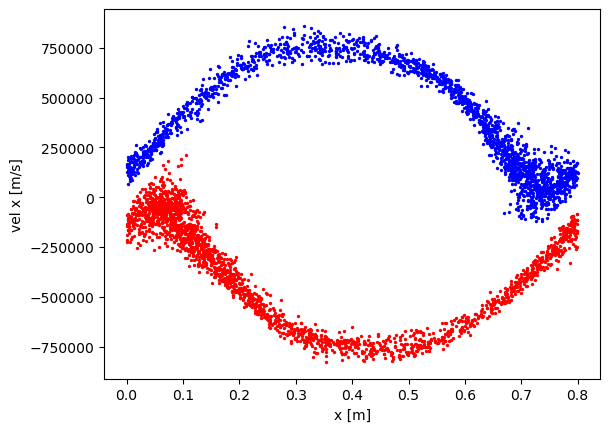

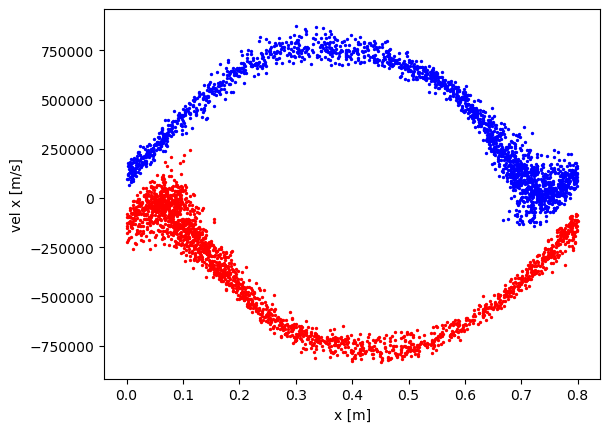

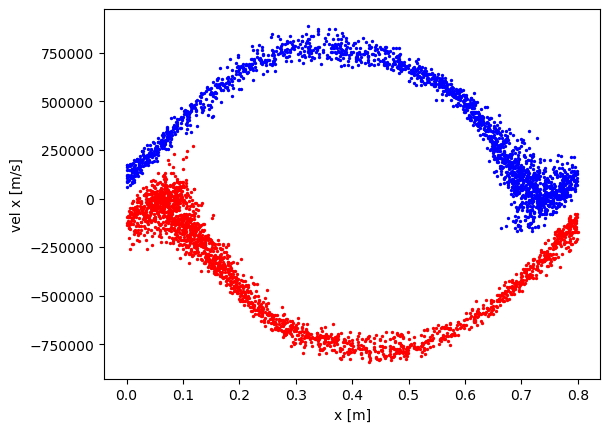

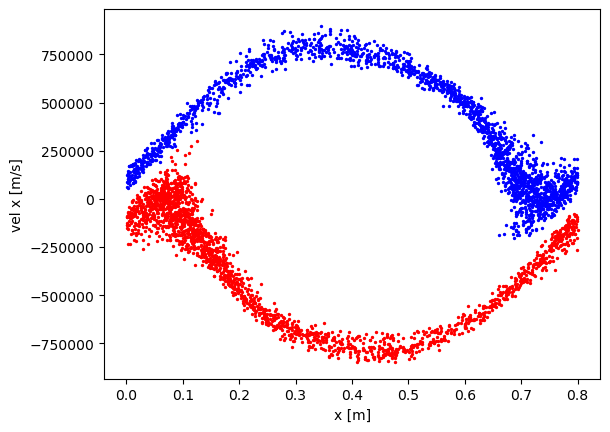

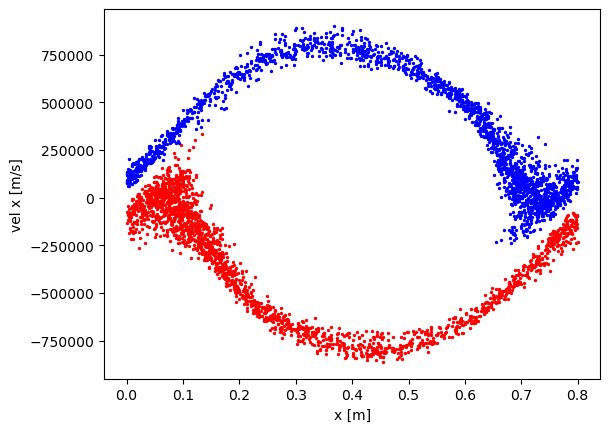

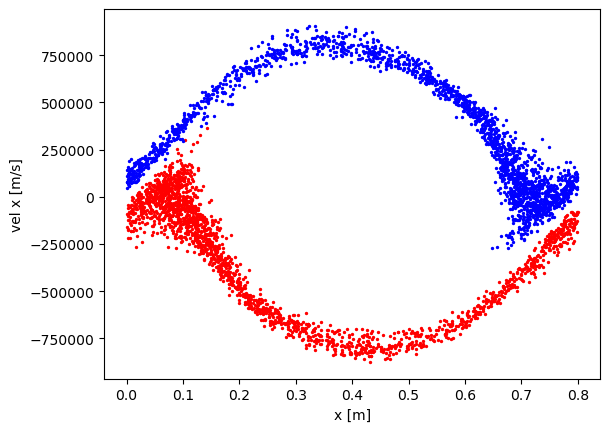

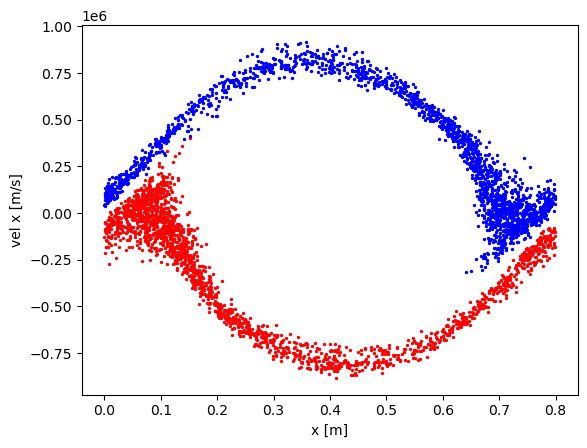

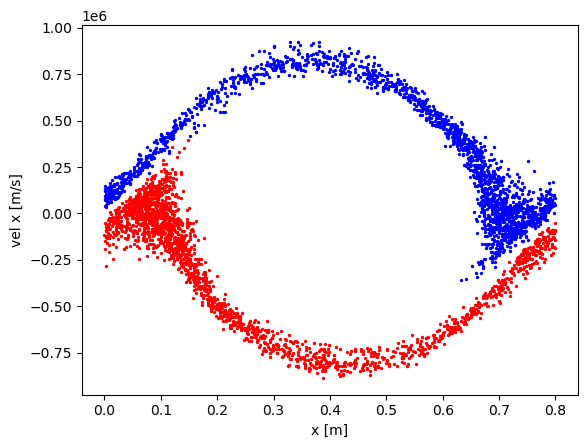

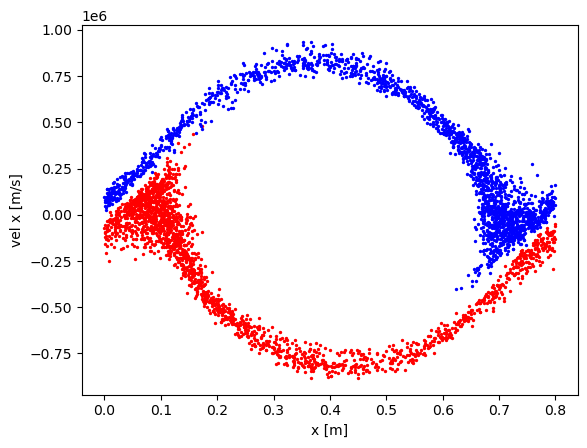

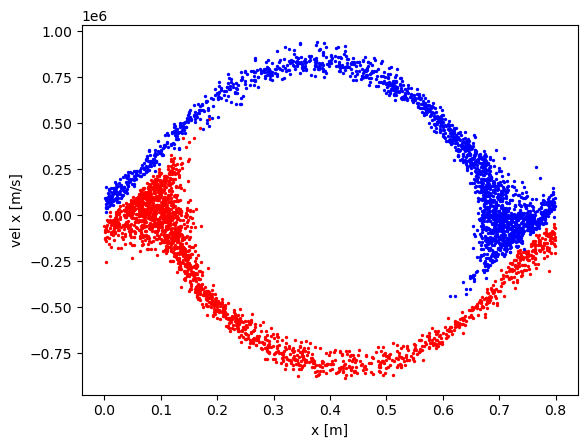

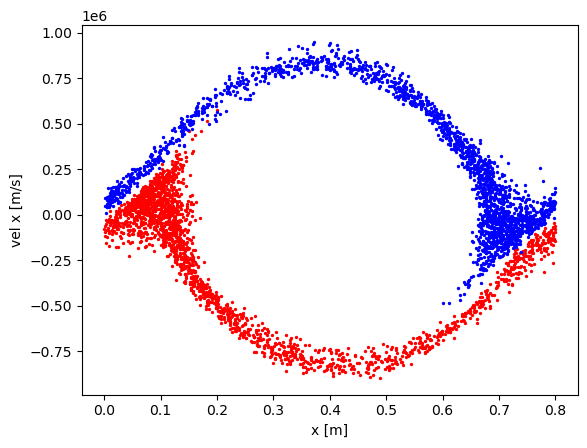

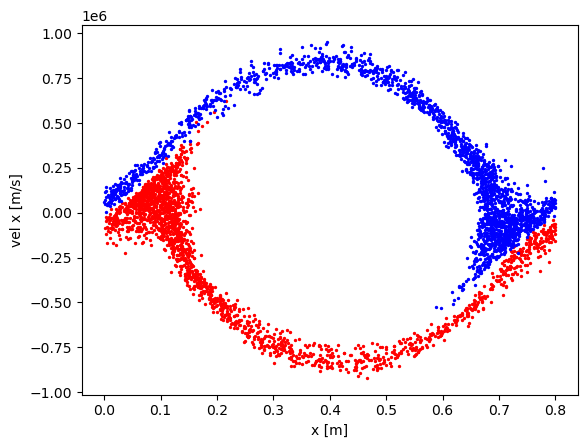

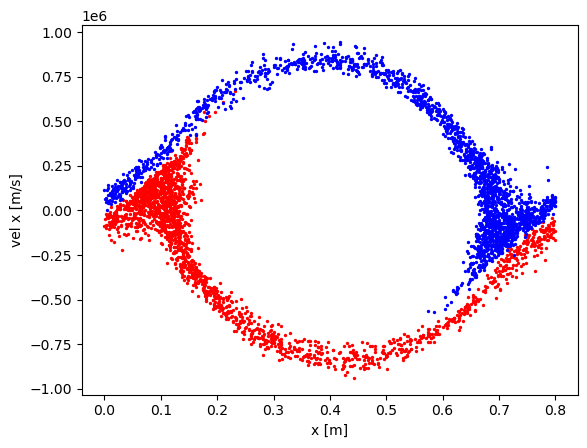

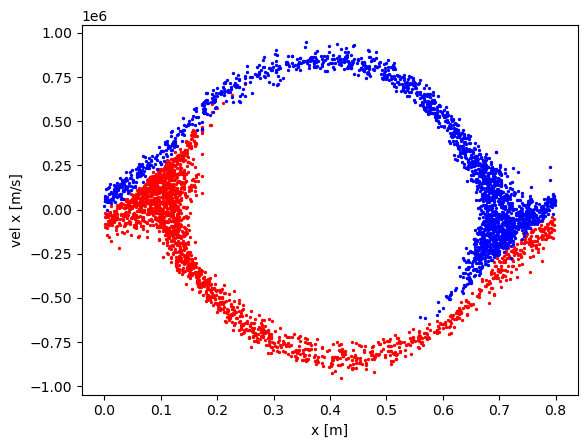

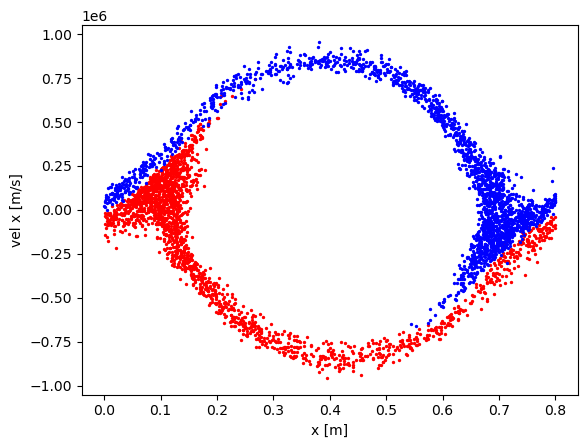

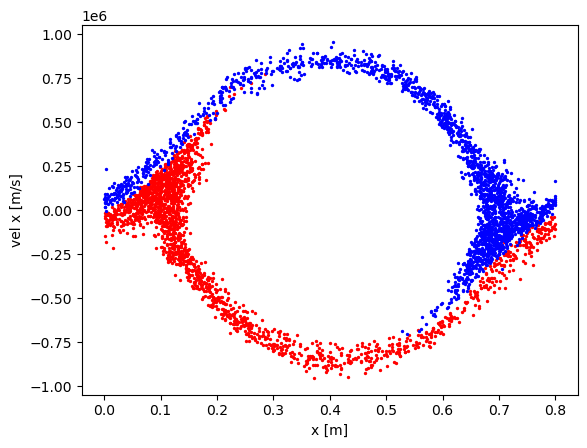

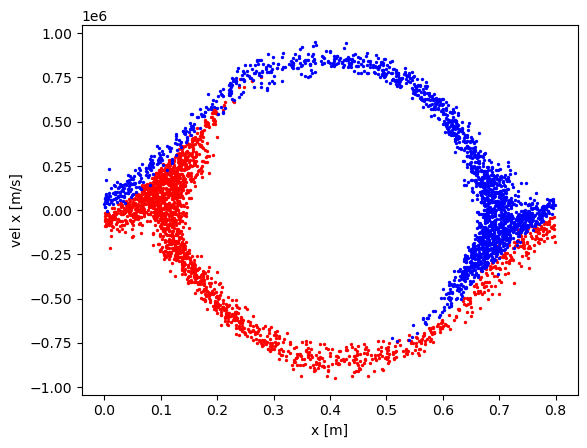

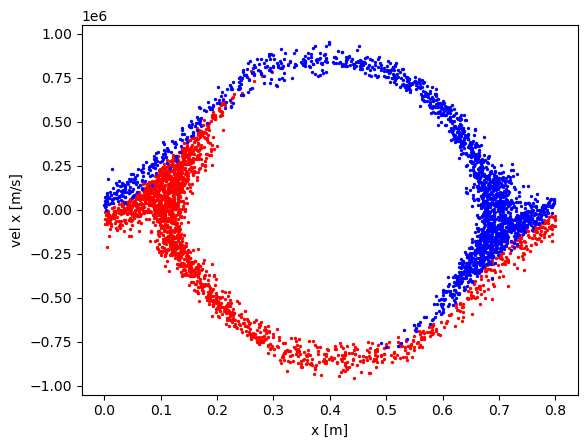

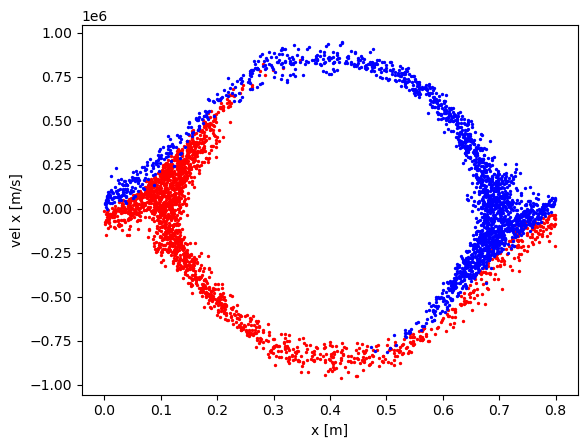

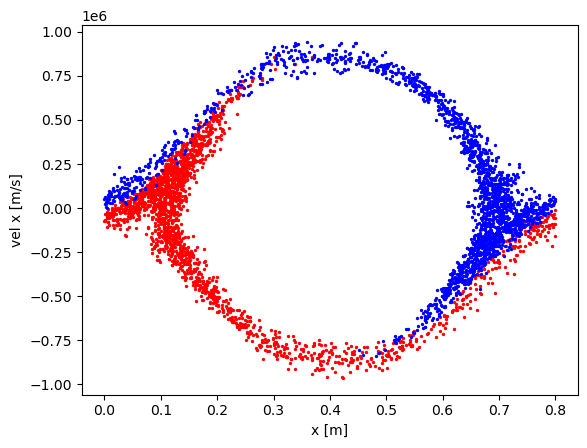

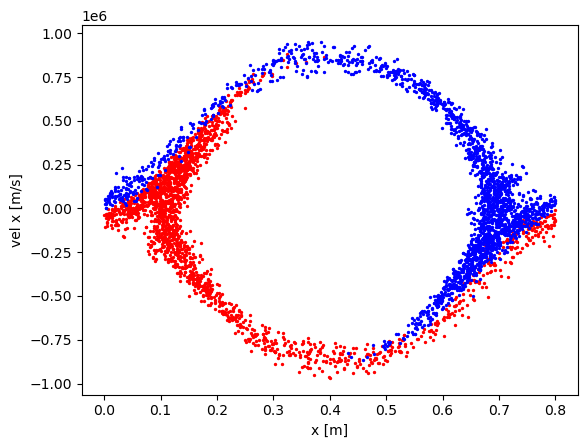

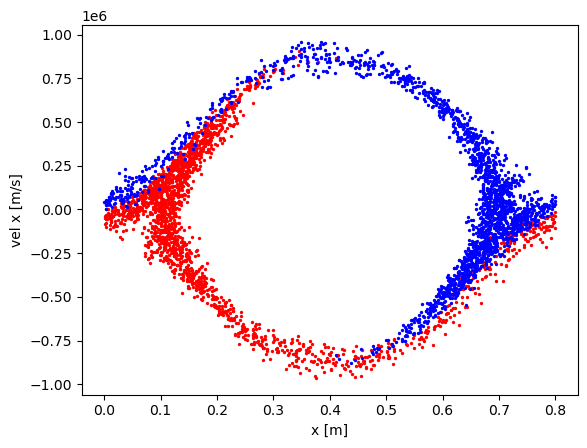

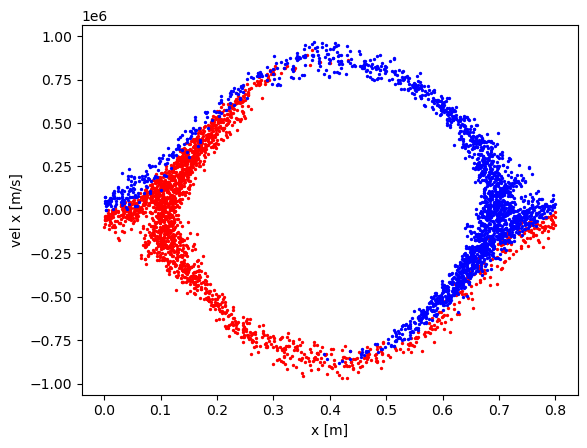

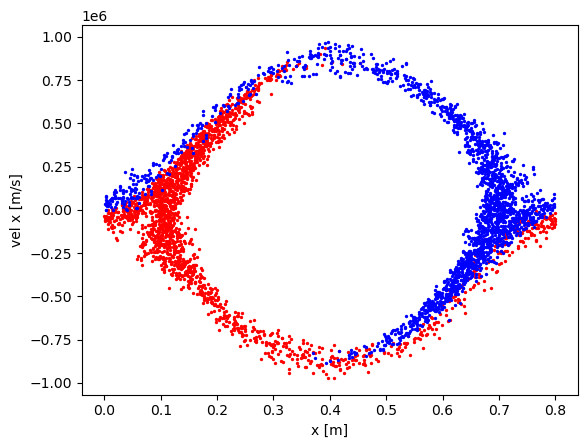

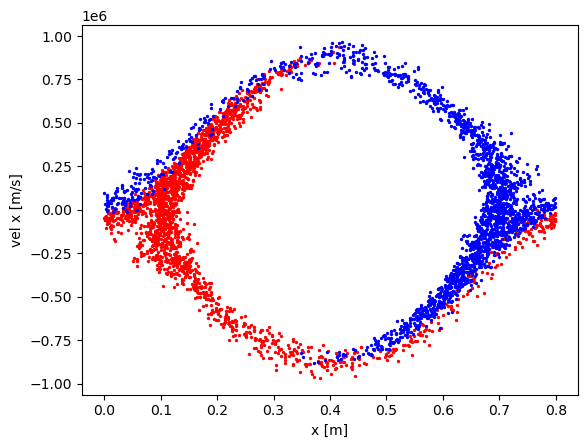

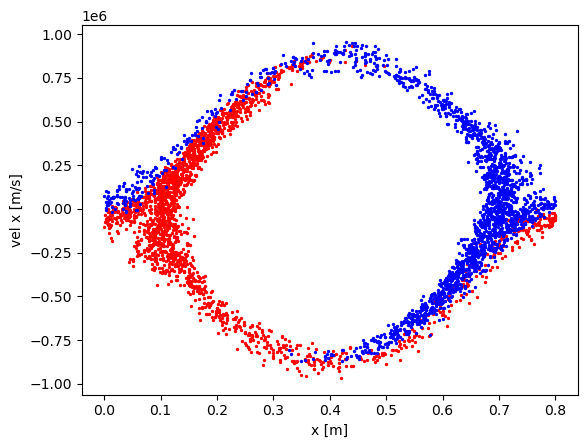

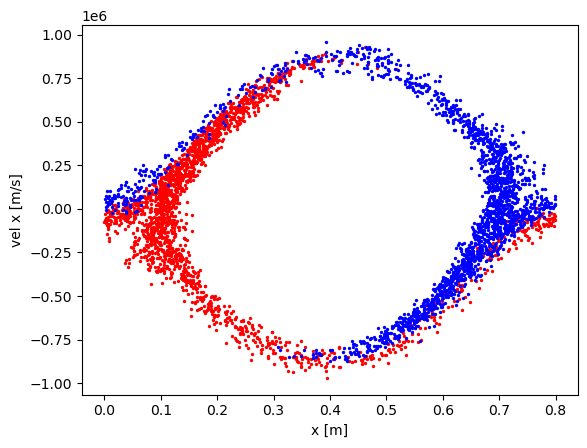

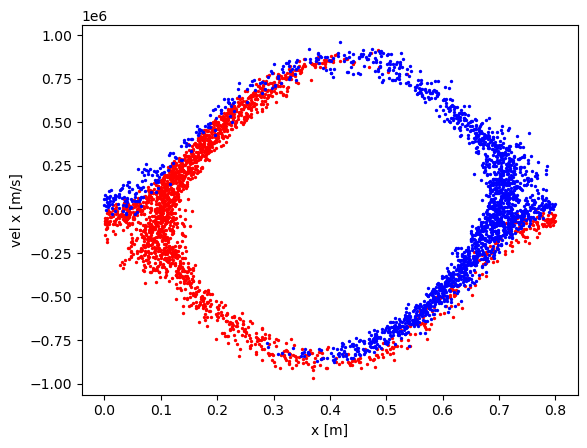

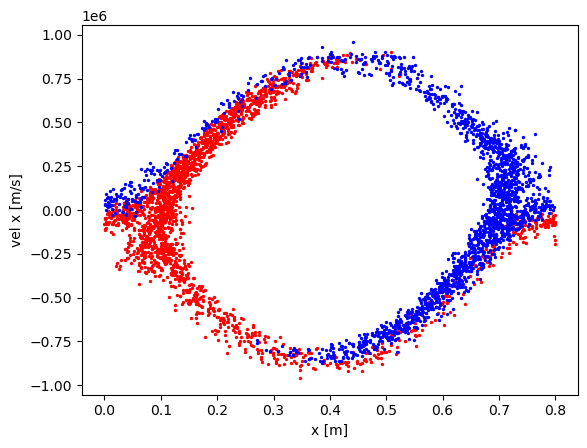

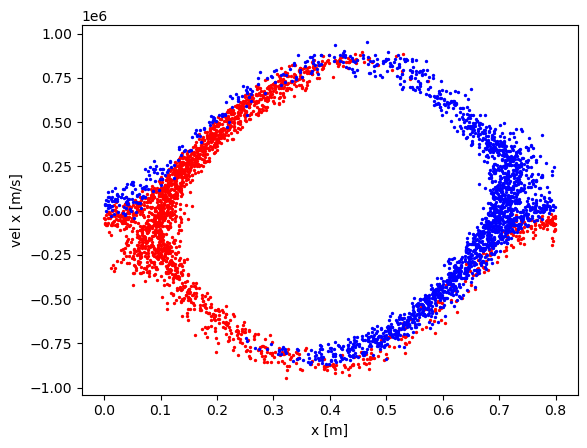

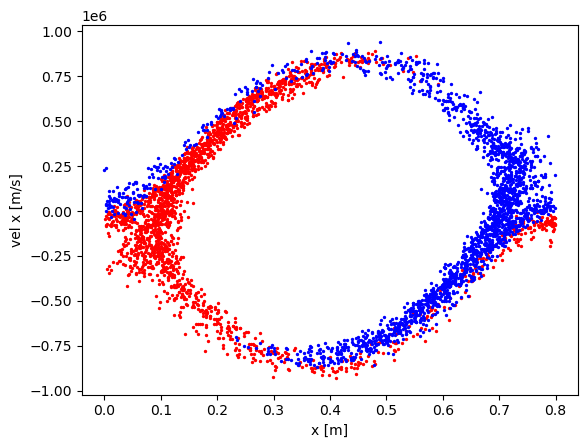

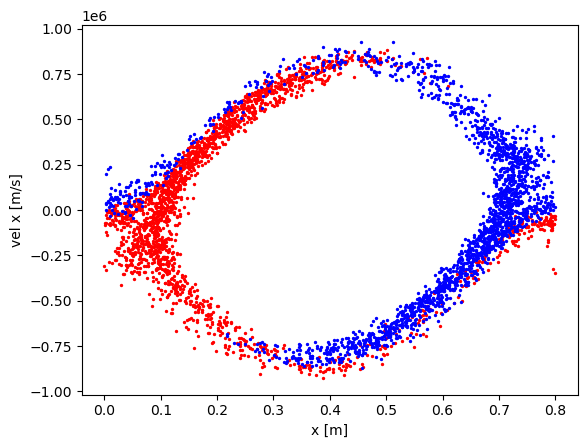

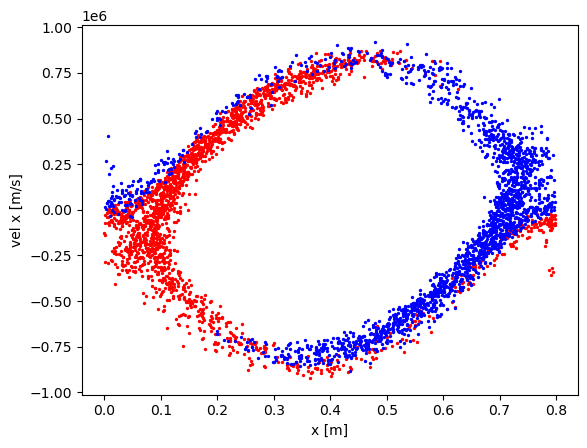

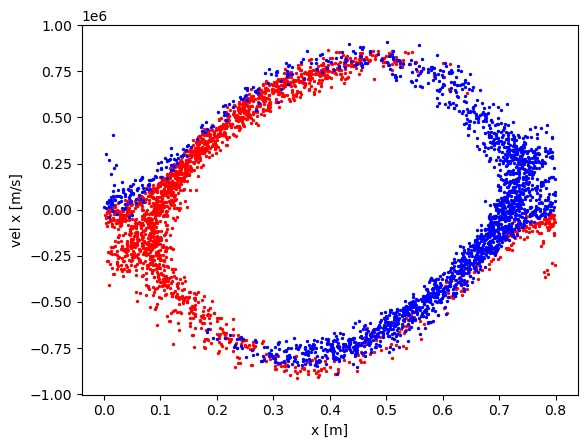

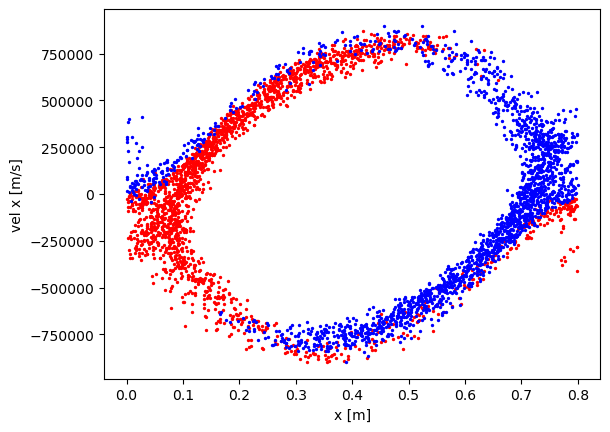

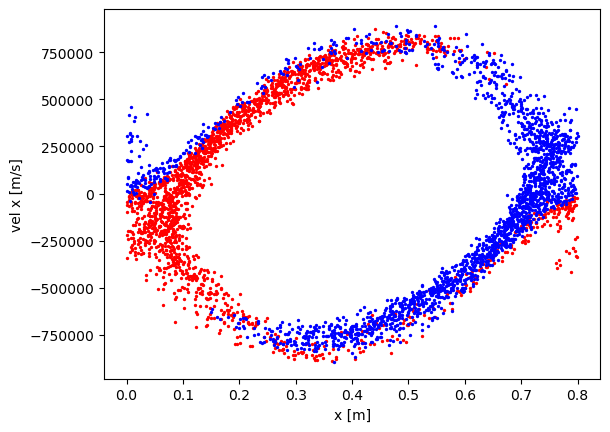

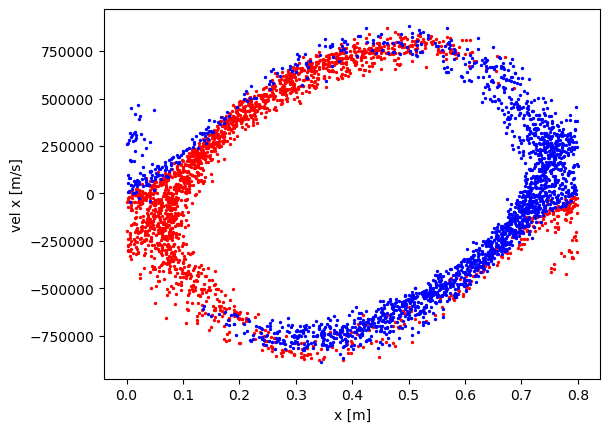

In [4]:
NP = 2048 #2048
d = 4.5e9
electrons, ions = generate_particles!(NP, d)

Δt = 1e-9
timesteps = 3000

historyxx = []
historyvel = []
EK = []
EE = []
EP = []

for i = 1:timesteps
    println(i)
    PIC3D.timestep!(electrons, ions)
    if i % 25 == 0
        plt.figure()
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 0],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 0], color="red", label="c = 1", s=2)
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 1],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 1], color="blue", label="c = 1", s=2)
        plt.xlabel("x [m]")
        plt.ylabel("vel x [m/s]")
        plt.show()
        push!(historyxx, [[ex...] for ex in electrons.x])
        push!(historyvel, [[ev...] for ev in electrons.v])
    end
    push!(EK, compute_EK_particles(electrons, ions))
    push!(EE, compute_EP_field())
    push!(EP, compute_EP_potential())
end

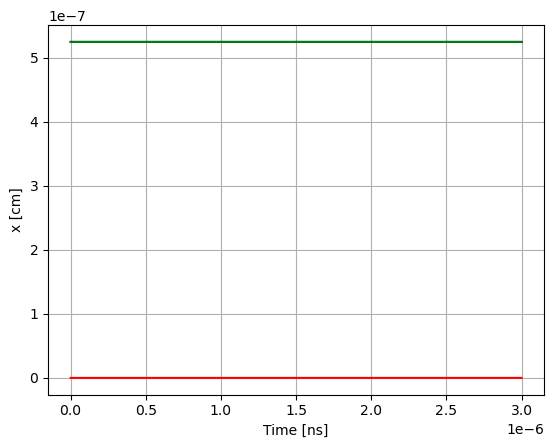

PyObject Text(24.000000000000007, 0.5, 'x [cm]')

In [6]:
fig = plt.figure()
times = [i*Δt for i=1:timesteps]
plt.plot(times, EE , linestyle="solid", color="red")
plt.plot(times, EK , linestyle="solid", color="blue")
plt.plot(times, EE  + EK , linestyle="solid", color="green")
#plt.plot(times, EP ./ EK[1], linestyle="solid", color="black")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")

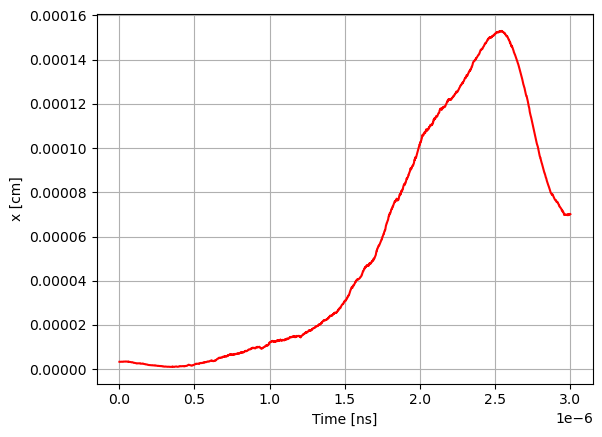

PyObject Text(24.0, 0.5, 'x [cm]')

In [7]:
fig = plt.figure()
times = [i*Δt for i=1:timesteps]
plt.plot(times, EE ./ EK[1], linestyle="solid", color="red")
#plt.plot(times, EK ./ EK[1], linestyle="solid", color="blue")
#plt.plot(times, EE ./ EK[1] + EK ./ EK[1], linestyle="solid", color="green")
#plt.plot(times, EP ./ EK[1], linestyle="solid", color="black")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")

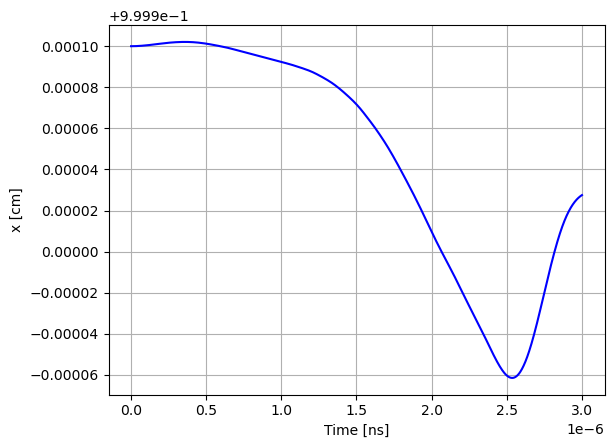

PyObject Text(24.0, 0.5, 'x [cm]')

In [8]:
fig = plt.figure()
times = [i*Δt for i=1:timesteps]
#plt.plot(times, EE ./ EK[1], linestyle="solid", color="red")
plt.plot(times, EK ./ EK[1], linestyle="solid", color="blue")
#plt.plot(times, EE ./ EK[1] + EK ./ EK[1], linestyle="solid", color="green")
#plt.plot(times, EP ./ EK[1], linestyle="solid", color="black")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")